In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


In [4]:
def calculate_wmape(actual, forecast, weights=None):
    """
    Calculate the Weighted Mean Absolute Percentage Error (WMAPE) between two series.

    Parameters:
    actual (list or array): The actual values.
    forecast (list or array): The forecasted values.
    weights (list or array, optional): Weight for each observation. Default is None (equal weights).

    Returns:
    float: The calculated WMAPE.
    """
    if len(actual) != len(forecast):
        raise ValueError("Both series must have the same length.")

    if weights is None:
        weights = [1] * len(actual)

    if len(weights) != len(actual):
        raise ValueError("Number of weights must match the length of the series.")

    total_weighted_absolute_percentage_error = 0
    total_weights = sum(weights)

    for i in range(len(actual)):
        abs_percentage_error = abs((actual[i] - forecast[i]) / actual[i]) * 100
        weighted_abs_percentage_error = abs_percentage_error * weights[i]
        total_weighted_absolute_percentage_error += weighted_abs_percentage_error

    wmape_score = total_weighted_absolute_percentage_error / total_weights
    return wmape_score

def calculate_mape(actual, forecast):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between two series.

    Parameters:
    actual (list or array): The actual values.
    forecast (list or array): The forecasted values.

    Returns:
    float: The calculated MAPE.
    """
    if len(actual) != len(forecast):
        raise ValueError("Both series must have the same length.")

    total_absolute_percentage_error = 0

    for i in range(len(actual)):
        abs_percentage_error = abs((actual[i] - forecast[i]) / actual[i]) * 100
        total_absolute_percentage_error += abs_percentage_error

    mape_score = total_absolute_percentage_error / len(actual)
    return mape_score

def calc_wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

def calc_mae (y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / len(y_true)

# Objetivo

Você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA para criar uma série temporal e prever diariamente o fechamento da base.

- Apresentar modelo com storytelling;

- Justificar a técnica utilizada;

- Atingir acurácia mínimia de 70%.

**Dados**: https://br.investing.com/indices/bovespa-historical-data

# Leitura e processamento dos dados

In [5]:
dados_path = "D:\DOWN\Dados Históricos - Ibovespa.csv"

dados = pd.read_csv(dados_path)

dados

Data   Último  Abertura   Máxima   Mínima    Vol.    Var%
0     27.06.2024  124.308   122.642  124.308  122.642   8,71M   1,36%
1     26.06.2024  122.641   122.331  122.701  121.402   8,18M   0,25%
2     25.06.2024  122.331   122.634  122.849  121.997   6,94M  -0,25%
3     24.06.2024  122.637   121.343  122.840  121.307   7,84M   1,07%
4     21.06.2024  121.341   120.446  121.580  120.061  12,91M   0,74%
...          ...      ...       ...      ...      ...     ...     ...
2330  30.01.2015   46.908    47.759   47.759   46.484   4,85M  -1,79%
2331  29.01.2015   47.762    47.696   47.894   47.007   4,41M   0,14%
2332  28.01.2015   47.695    48.589   48.589   47.550   4,24M  -1,84%
2333  27.01.2015   48.591    48.577   48.864   47.352   3,89M   0,03%
2334  26.01.2015   48.577    48.712   48.712   48.004   2,77M  -0,41%

[2335 rows x 7 columns]

In [6]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      2335 non-null   object 
 1   Último    2335 non-null   float64
 2   Abertura  2335 non-null   float64
 3   Máxima    2335 non-null   float64
 4   Mínima    2335 non-null   float64
 5   Vol.      2334 non-null   object 
 6   Var%      2335 non-null   object 
dtypes: float64(4), object(3)
memory usage: 127.8+ KB
None


In [7]:
print(dados.isna().sum())

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64


Existem algumas inconsistências na base. Coluna de data está como tipo texto, variáveis numéricas em formato texto e existe um valor nulo na coluna "Vol."

## Ajuste nos tipos de dados

In [8]:
# Coluna Data com tipo datetime
dados = pd.read_csv(dados_path, parse_dates=[0], dayfirst=True)

dados.head()

Data   Último  Abertura   Máxima   Mínima    Vol.    Var%
0 2024-06-27  124.308   122.642  124.308  122.642   8,71M   1,36%
1 2024-06-26  122.641   122.331  122.701  121.402   8,18M   0,25%
2 2024-06-25  122.331   122.634  122.849  121.997   6,94M  -0,25%
3 2024-06-24  122.637   121.343  122.840  121.307   7,84M   1,07%
4 2024-06-21  121.341   120.446  121.580  120.061  12,91M   0,74%

In [9]:
dados['Vol.'] = dados['Vol.'].str[:-1]
dados['Var%'] = dados['Var%'].str[:-1]

dados['Vol.'] = dados['Vol.'].str.replace(',','.')
dados['Var%'] = dados['Var%'].str.replace(',','.')

dados['Vol.'] = dados['Vol.'].astype(float)
dados['Var%'] = dados['Var%'].astype(float)

In [10]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      2335 non-null   datetime64[ns]
 1   Último    2335 non-null   float64       
 2   Abertura  2335 non-null   float64       
 3   Máxima    2335 non-null   float64       
 4   Mínima    2335 non-null   float64       
 5   Vol.      2334 non-null   float64       
 6   Var%      2335 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 127.8 KB
None


## Valores nulos

In [11]:
dados.loc[dados['Vol.'].isna()]

Data  Último  Abertura  Máxima  Mínima  Vol.  Var%
2080 2016-02-10  40.377    40.592  40.592   39.96   NaN -0.53

Por se tratar de apenas uma linha no dataframe, será adotada a técnica de exclusão da linha com valores nulos, pois não prejudicará a representação dos dados.

In [12]:
dados.dropna(inplace=True)

dados.loc[dados['Vol.'].isna()]

Empty DataFrame
Columns: [Data, Último, Abertura, Máxima, Mínima, Vol., Var%]
Index: []

## Renomeando colunas

Para facilitar as análises futuras e simplificar a nomenclatura das variáveis, os nomes das colunas também serão modificados

In [13]:
print(dados.columns)

Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')


In [14]:
dados.columns = ['ds', 'y', 'abertura', 'max', 'min', 'volume', 'variacao']

dados.head()

ds        y  abertura      max      min  volume  variacao
0 2024-06-27  124.308   122.642  124.308  122.642    8.71      1.36
1 2024-06-26  122.641   122.331  122.701  121.402    8.18      0.25
2 2024-06-25  122.331   122.634  122.849  121.997    6.94     -0.25
3 2024-06-24  122.637   121.343  122.840  121.307    7.84      1.07
4 2024-06-21  121.341   120.446  121.580  120.061   12.91      0.74

## Exportação da base processada

In [15]:
dados.to_csv("D:\DOWN\Dados Históricos - Ibovespa_tratada.csv", index=False)

# Exploratory Data Analysis

## Variação

In [16]:
print(f'Variação máxima (%): {dados.variacao.max()}')
print(dados.loc[dados.variacao == dados.variacao.max()]['ds'])

print('\n')

print(f'Variação mínima (%): {dados.variacao.min()}')
print(dados.loc[dados.variacao == dados.variacao.min()]['ds'])

Variação máxima (%): 13.91
1067   2020-03-13
Name: ds, dtype: datetime64[ns]


Variação mínima (%): -14.78
1068   2020-03-12
Name: ds, dtype: datetime64[ns]


Os picos de variação máxima e mínima do índica IBOVESPA ocorreram em períodos bem próximos na linha do tempo.

Tanto o máximo de desvalorização  como o de valorização da bolsa ocorreram no ano de 2020, provavelmente efeito da pandemia. É um alerta de como esse ano foi atípico, tais dados podem não ser bons conjuntos de treino e teste

d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


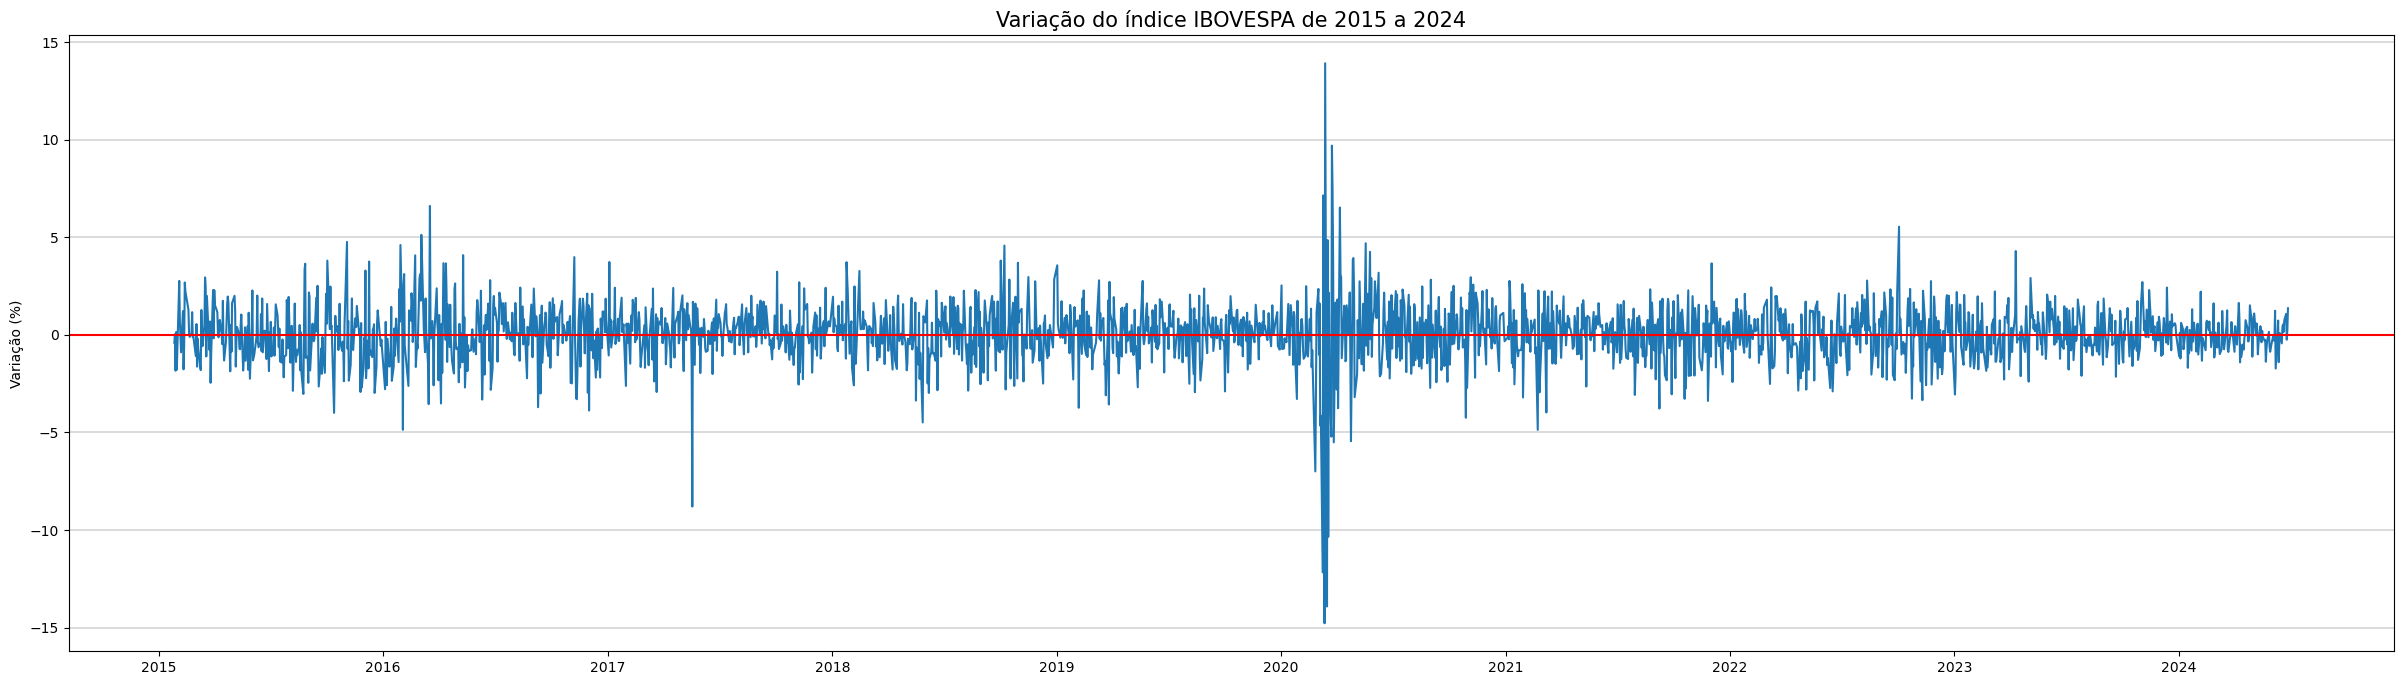

In [17]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='variacao', ax=ax)
ax.axhline(y=0, color='red')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do índice IBOVESPA de 2015 a 2024', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Variação (%)')

plt.show()

Percebe-se um gráfico com muitos altos e baixos, porém com a maioria dos valores entre -5% e +5% de variação. 

Ocorrem alguns pontos no gráfico em que a variação ultrapassa esses valores, com destaque novamente para o ano de 2020 que apresentou o comportamento mais incostante na série. Por conta do circuit breaker e pandemia

## Volume

Total de valores negociados no dia, em milhões R$

In [18]:
print(f'Volume máximo (milhões R$): {dados.volume.max()}')
print(dados.loc[dados.volume == dados.volume.max()]['ds'])

print('\n')

print(f'Volume mínimo (milhões R$): {dados.volume.min()}')
print(dados.loc[dados.volume == dados.volume.min()]['ds'])

Volume máximo (milhões R$): 980.07
1731   2017-07-04
Name: ds, dtype: datetime64[ns]


Volume mínimo (milhões R$): 1.21
2005   2016-05-30
Name: ds, dtype: datetime64[ns]


d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


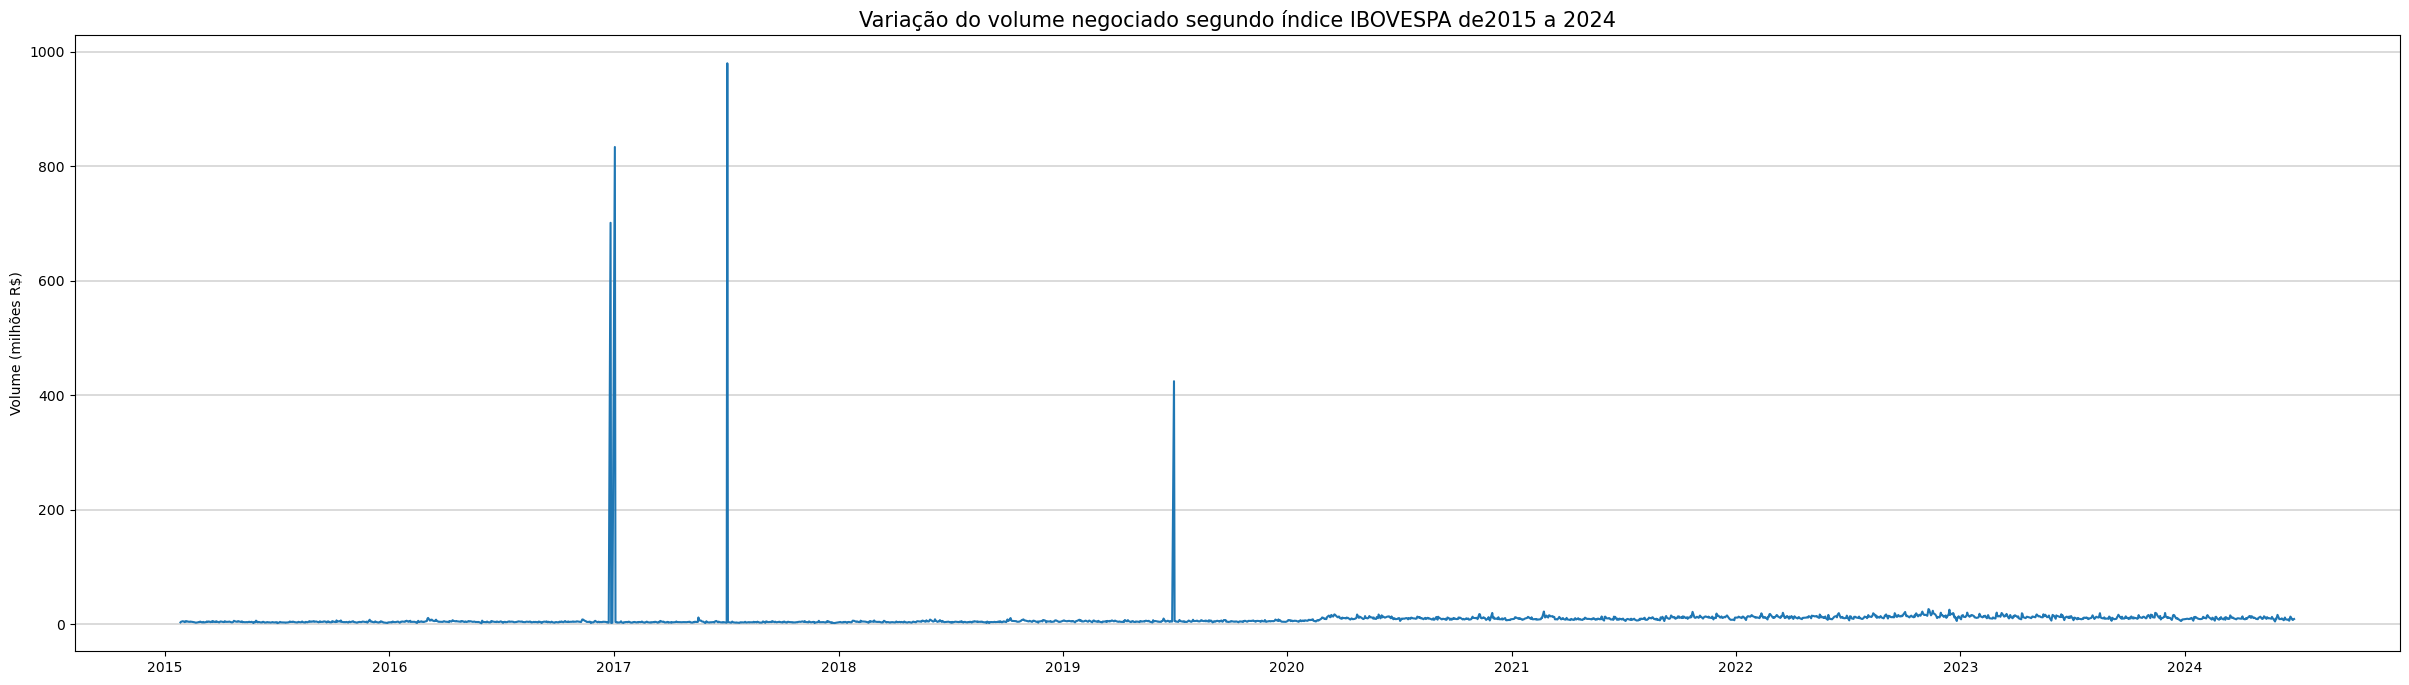

In [19]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='volume', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do volume negociado segundo índice IBOVESPA de2015 a 2024', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Volume (milhões R$)')

plt.show()

O gráfico indica outliers muito acima do normal para os valores de volume negociados em bolsa, é um indício que a base de dados pode ter inconsistências nesse sentido.

Checando na base original, foi verificado que existiam valores na unidade de milhares de R$ em meio à grande maioria das linhas representadas em milhões de R$. Ou seja, os outliers que surgiram na verdade devem ser divididos por 1000 para ajustá-los para a unidade milhões de R$

In [20]:
# Linhas da base com volume em milhares de R$
dados.loc[dados.volume > 100]

ds        y  abertura      max      min  volume  variacao
1242 2019-07-01  101.340   100.973  102.432  100.973  424.32      0.37
1731 2017-07-04   63.232    63.268   63.346   63.076  980.07     -0.08
1855 2017-01-02   59.589    60.227   60.227   59.371  833.73     -1.06
1859 2016-12-26   58.620    57.941   58.781   57.941  701.23      1.18

In [21]:
# Conversão para milhões de R$
dados.loc[dados.volume > 100, 'volume'] = dados.volume/1000

In [22]:
dados.loc[dados.volume > 100]

Empty DataFrame
Columns: [ds, y, abertura, max, min, volume, variacao]
Index: []

In [23]:
print(f'Volume máximo (milhões R$): {dados.volume.max()}')
print(dados.loc[dados.volume == dados.volume.max()]['ds'])

print('\n')

print(f'Volume mínimo (milhões R$): {dados.volume.min()}')
print(dados.loc[dados.volume == dados.volume.min()]['ds'])

Volume máximo (milhões R$): 26.03
405   2022-11-10
Name: ds, dtype: datetime64[ns]


Volume mínimo (milhões R$): 0.42432
1242   2019-07-01
Name: ds, dtype: datetime64[ns]


d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_27196\883438799.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


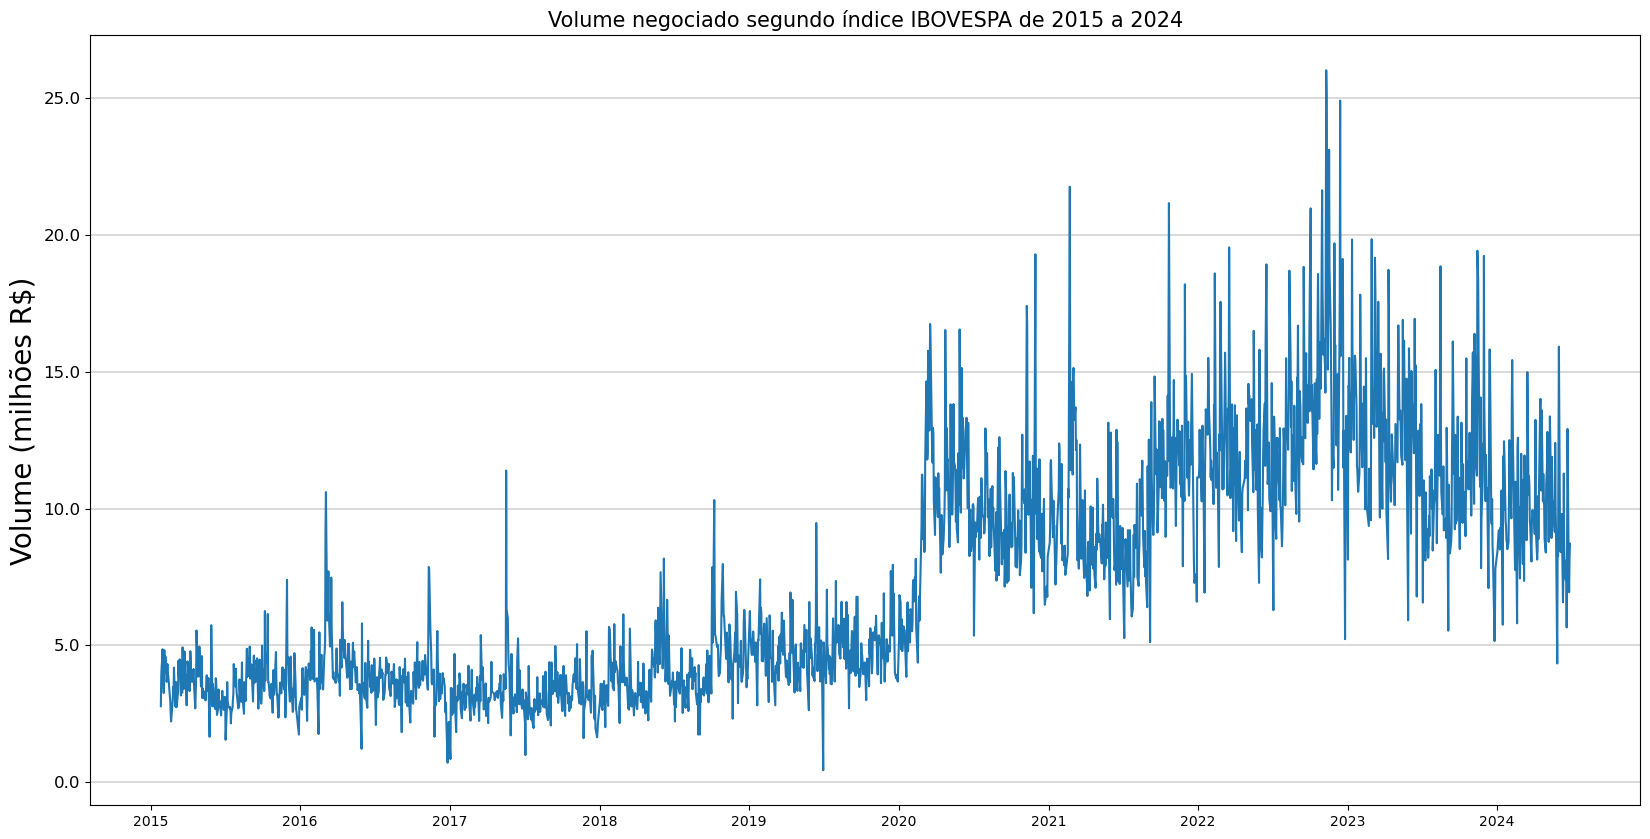

In [24]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(dados, x='ds', y='volume', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Volume negociado segundo índice IBOVESPA de 2015 a 2024', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Volume (milhões R$)', fontsize=20)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)
#ax.set_xticklabels(ax.get_xticks(), fontsize=15)

plt.show()

Agora, o gráfico ilustra bem a evolução do mercado variável no Brasil. É visível que, até meados de 2019, o volume de negociações sofreu pouca alteração com uma leve tendência de crescimento.

Com a redução nas taxas de juros e Selic, e consequentemente a baixa nos investimentos de Renda Fixa, o mercado de Renda Variável teve um "boom" a partir do ano de 2020.

principalmente com os novos influenciadores e o boom da pandemia.

## Diferença entre índice mínimo e máximo diário

Com a diferença entre as variáveis "min" e "max" é possível identificar dias em que o índice IBOVESPA sofreu maior alteração durante as próprias negociações do dia. 

Desta forma, pode-se verificar dias atípicos, possivelmente causados por fatores e eventos político-econômicos importantes, que resultaram na flutuação do índice durante o período de um dia.

In [25]:
dados['dif_min_max'] = dados['max'] - dados['min']
dados

ds        y  abertura      max      min  volume  variacao  \
0    2024-06-27  124.308   122.642  124.308  122.642    8.71      1.36   
1    2024-06-26  122.641   122.331  122.701  121.402    8.18      0.25   
2    2024-06-25  122.331   122.634  122.849  121.997    6.94     -0.25   
3    2024-06-24  122.637   121.343  122.840  121.307    7.84      1.07   
4    2024-06-21  121.341   120.446  121.580  120.061   12.91      0.74   
...         ...      ...       ...      ...      ...     ...       ...   
2330 2015-01-30   46.908    47.759   47.759   46.484    4.85     -1.79   
2331 2015-01-29   47.762    47.696   47.894   47.007    4.41      0.14   
2332 2015-01-28   47.695    48.589   48.589   47.550    4.24     -1.84   
2333 2015-01-27   48.591    48.577   48.864   47.352    3.89      0.03   
2334 2015-01-26   48.577    48.712   48.712   48.004    2.77     -0.41   

      dif_min_max  
0           1.666  
1           1.299  
2           0.852  
3           1.533  
4           1.519  
...           ...  
2330        1.275  
2331        0.887  
2332        1.039  
2333        1.512  
2334        0.708  

[2334 rows x 8 columns]

d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


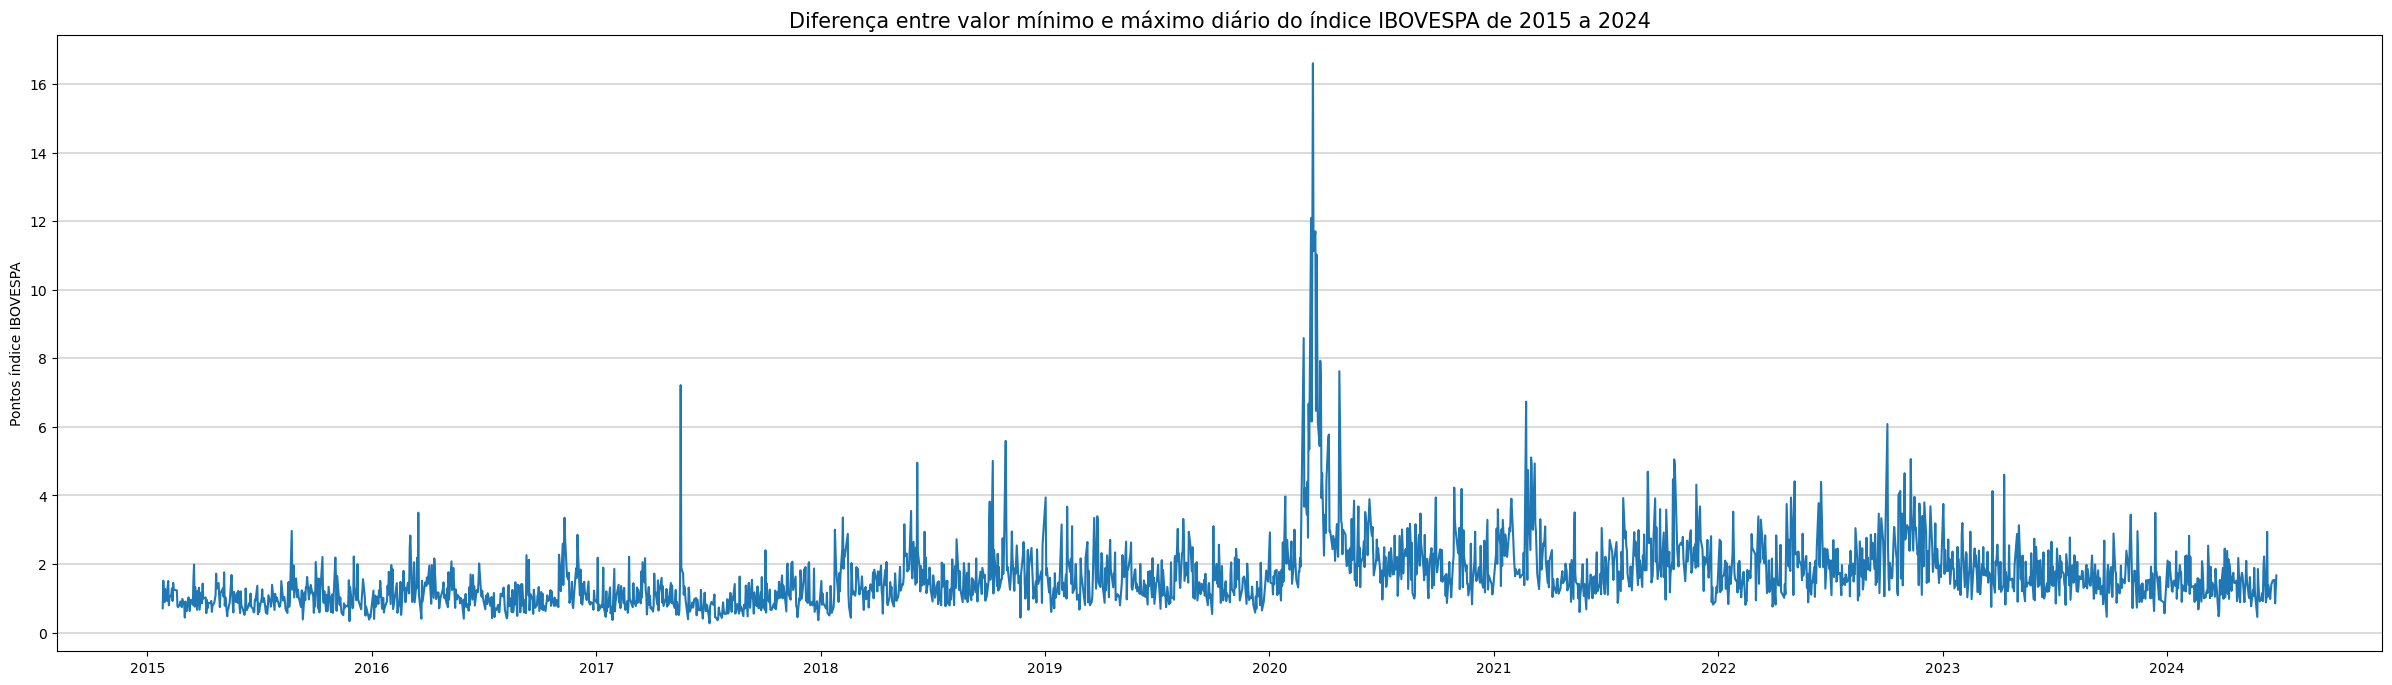

In [26]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='dif_min_max', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Diferença entre valor mínimo e máximo diário do índice IBOVESPA de 2015 a 2024', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

In [27]:
print('Número de dias com diferença entre mínimo e máximo maior que 5%:')
dados.loc[dados.dif_min_max > 5].ds.dt.year.value_counts()

Número de dias com diferença entre mínimo e máximo maior que 5%:


ds
2020    19
2021     3
2022     2
2018     2
2017     1
Name: count, dtype: int64

Este resultado reforça mais uma vez o comportamento atípico do IBOVESPA a partir de 2020. Possivelmente, 2021 e 2022 aparecem em seguida no rankin também por reflexo dos efeitos da crise causada pela pandemia.

## Fechamento

In [28]:
print(f'Índice máximo no fechamento: {dados.y.max()}')
print(dados.loc[dados.y == dados.y.max()]['ds'])

print('\n')

print(f'Índice máximo no fechamento: {dados.y.min()}')
print(dados.loc[dados.y == dados.y.min()]['ds'])

Índice máximo no fechamento: 134.194
124   2023-12-27
Name: ds, dtype: datetime64[ns]


Índice máximo no fechamento: 37.497
2089   2016-01-26
Name: ds, dtype: datetime64[ns]


d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


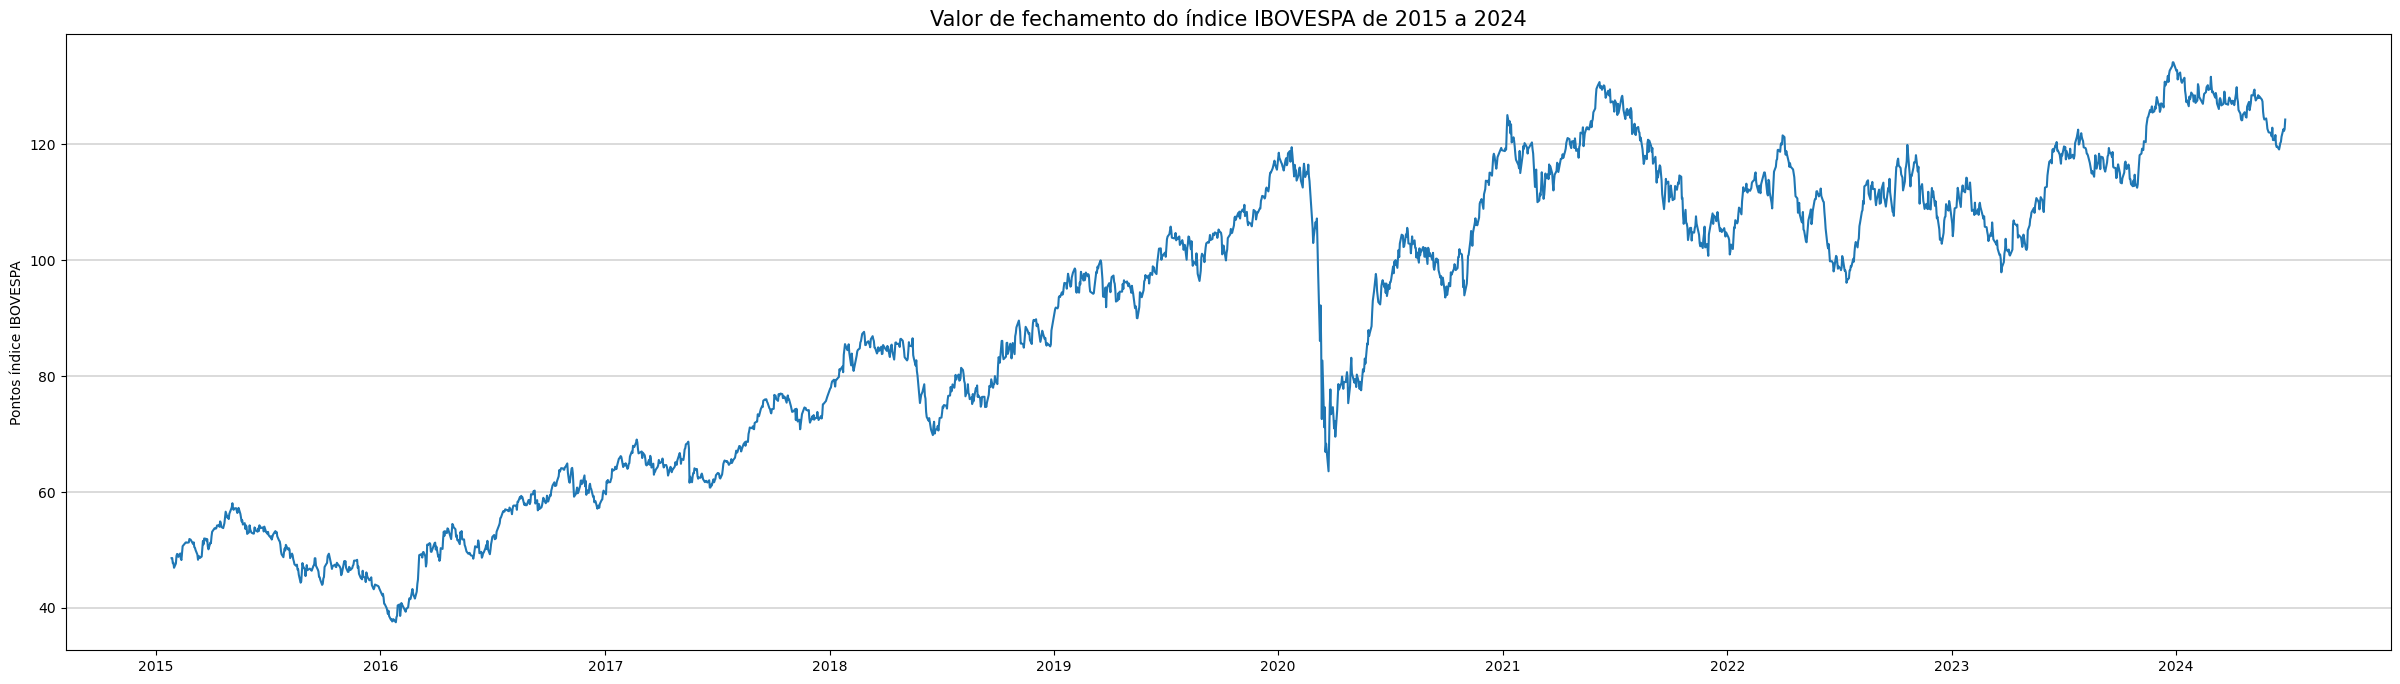

In [29]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados, x='ds', y='y', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Valor de fechamento do índice IBOVESPA de 2015 a 2024', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

Analisando a série temporal do valor de fechamento diário do IBOVESPA, de maneira geral ficam evidentes quatro momentos distintos:


1. Alta tendência de subida entre 2016 e 2020
3. Queda abrupta com a pandemia em 2020
4. Retomada da normalidade a partir do final de 2021, com série variando em momentos de queda e alta

d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


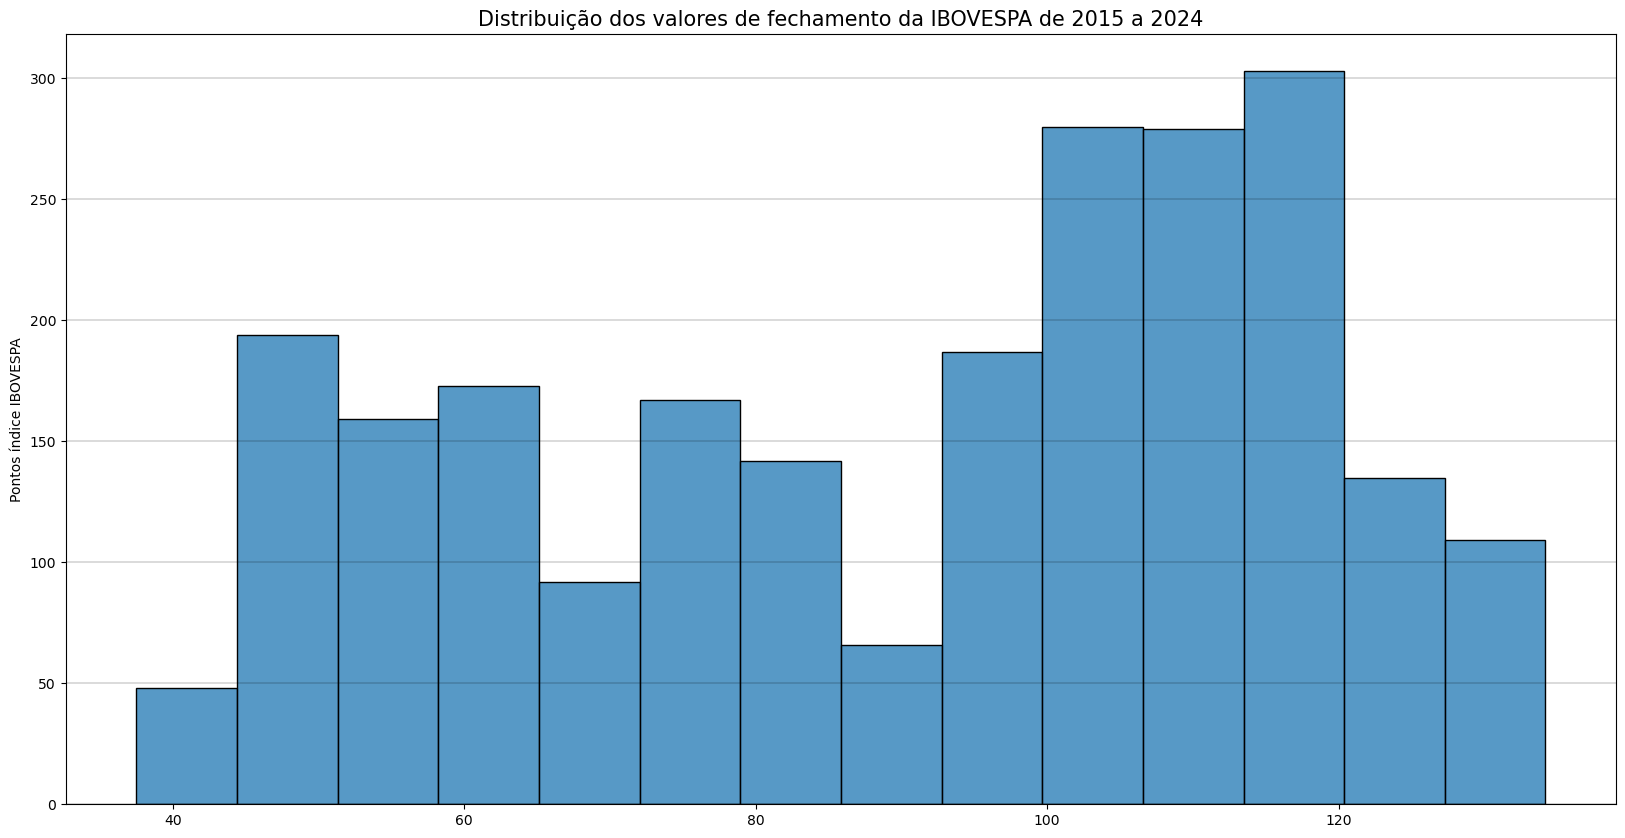

In [30]:
fig, ax = plt.subplots(figsize=(20,10))

sns.histplot(dados, x='y', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Distribuição dos valores de fechamento da IBOVESPA de 2015 a 2024', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

A série temporal se divide em basicamente dois grupos de acordo com o valor de fechamento. Primeiramente, o maior grupo que representa dias com valor de fechamento entre 50 e 80 pontos, relacionado principalmente aos de 2010 a 2016.

Já o segundo grande grupo concentra dias com valor de fechamento superior aos 100 pontos. Este grupo está relacionado principalmente ao período posterior ao ano de 2019.

## Volume x Fechamento

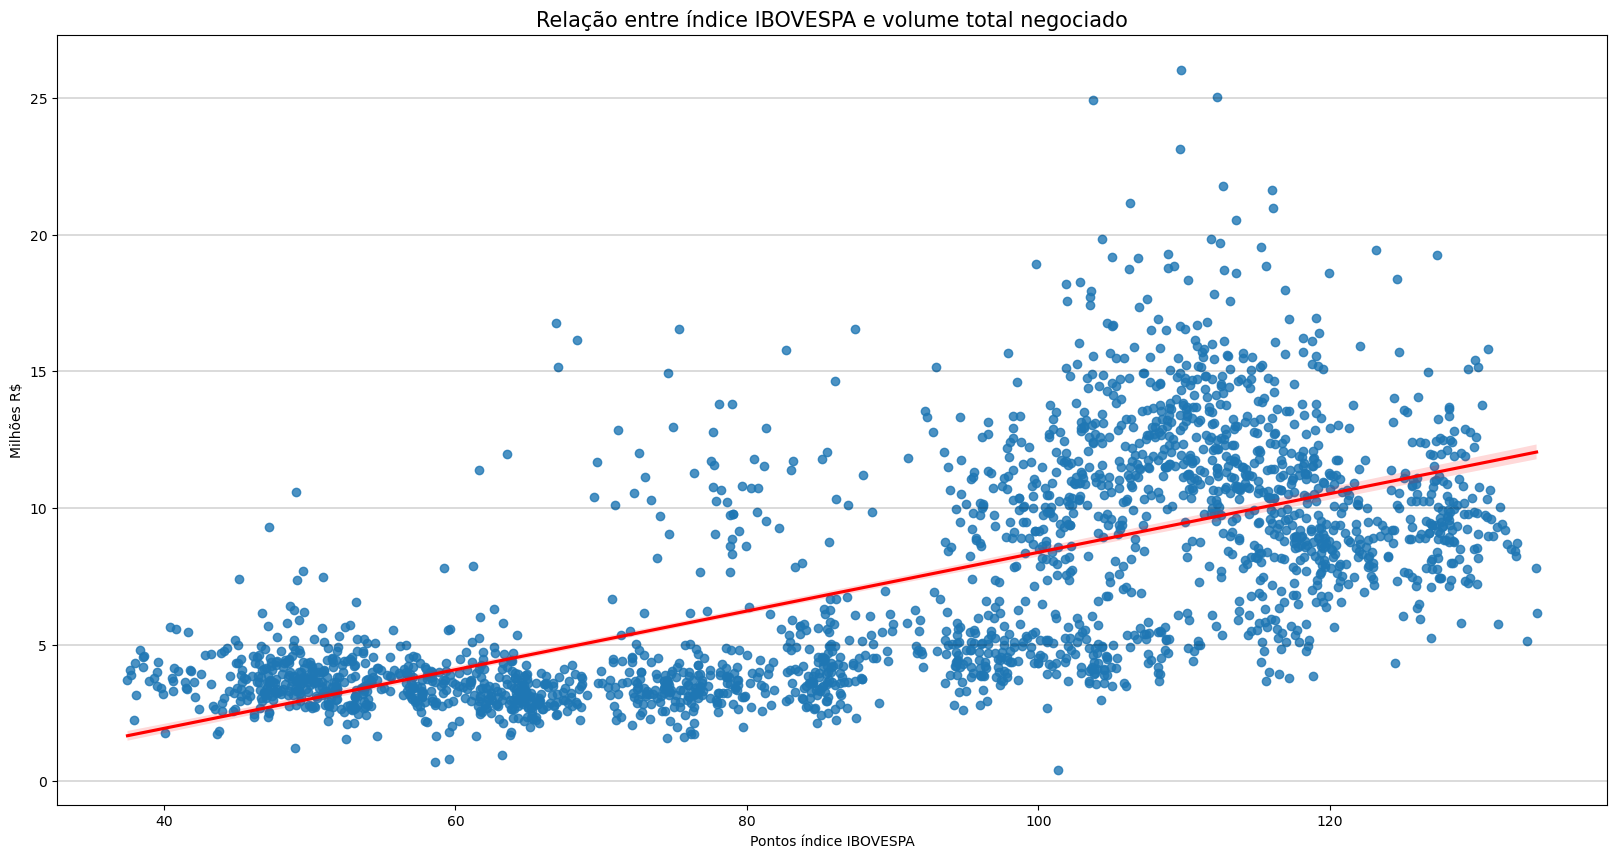

In [31]:
fig, ax = plt.subplots(figsize=(20,10))

sns.regplot(dados, x='y', y='volume', ax=ax, line_kws={'color':'red'})

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Relação entre índice IBOVESPA e volume total negociado', fontsize=15)
ax.set_xlabel('Pontos índice IBOVESPA')
ax.set_ylabel('Milhões R$')

plt.show()

In [32]:
print(dados[['y','volume']].corr())

               y    volume
y       1.000000  0.666944
volume  0.666944  1.000000


Neste gráfico de dispersão é possível visualizar uma forte correlação entre o valor do índice IBOVESPA e o volume negociado em bolsa. A correlação calculada é de 0.70, também um valor bastante alto.

# Série temporal original

## Componentes da série

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

Para ser possível visualizar as componentes da série, é necessário preencher as lacunas na série temporal causada por fins de semana e feriados.

Será utilizado o método ffill, que preenche valores NaN com o último valor válido da coluna.

In [34]:
# DataFrame com Index datetime
dados_date_index = dados[['ds','y']].copy()
dados_date_index.index = pd.to_datetime(dados_date_index.ds, format='%Y-%m-%d')
dados_date_index.drop(columns=['ds'], inplace=True)
dados_date_index = dados_date_index.asfreq('d')
dados_date_index.fillna(method='ffill', inplace=True)
display(dados_date_index)

# Dataframe com coluna datetime e unique_id
dados_date_col = dados_date_index.reset_index()
dados_date_col['unique_id'] = 'ibovespa'
display(dados_date_col)

C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_27196\4210217265.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados_date_index.fillna(method='ffill', inplace=True)


y
ds                 
2015-01-26   48.577
2015-01-27   48.591
2015-01-28   47.695
2015-01-29   47.762
2015-01-30   46.908
...             ...
2024-06-23  121.341
2024-06-24  122.637
2024-06-25  122.331
2024-06-26  122.641
2024-06-27  124.308

[3441 rows x 1 columns]

ds        y unique_id
0    2015-01-26   48.577  ibovespa
1    2015-01-27   48.591  ibovespa
2    2015-01-28   47.695  ibovespa
3    2015-01-29   47.762  ibovespa
4    2015-01-30   46.908  ibovespa
...         ...      ...       ...
3436 2024-06-23  121.341  ibovespa
3437 2024-06-24  122.637  ibovespa
3438 2024-06-25  122.331  ibovespa
3439 2024-06-26  122.641  ibovespa
3440 2024-06-27  124.308  ibovespa

[3441 rows x 3 columns]

In [35]:
result = seasonal_decompose(dados_date_index)

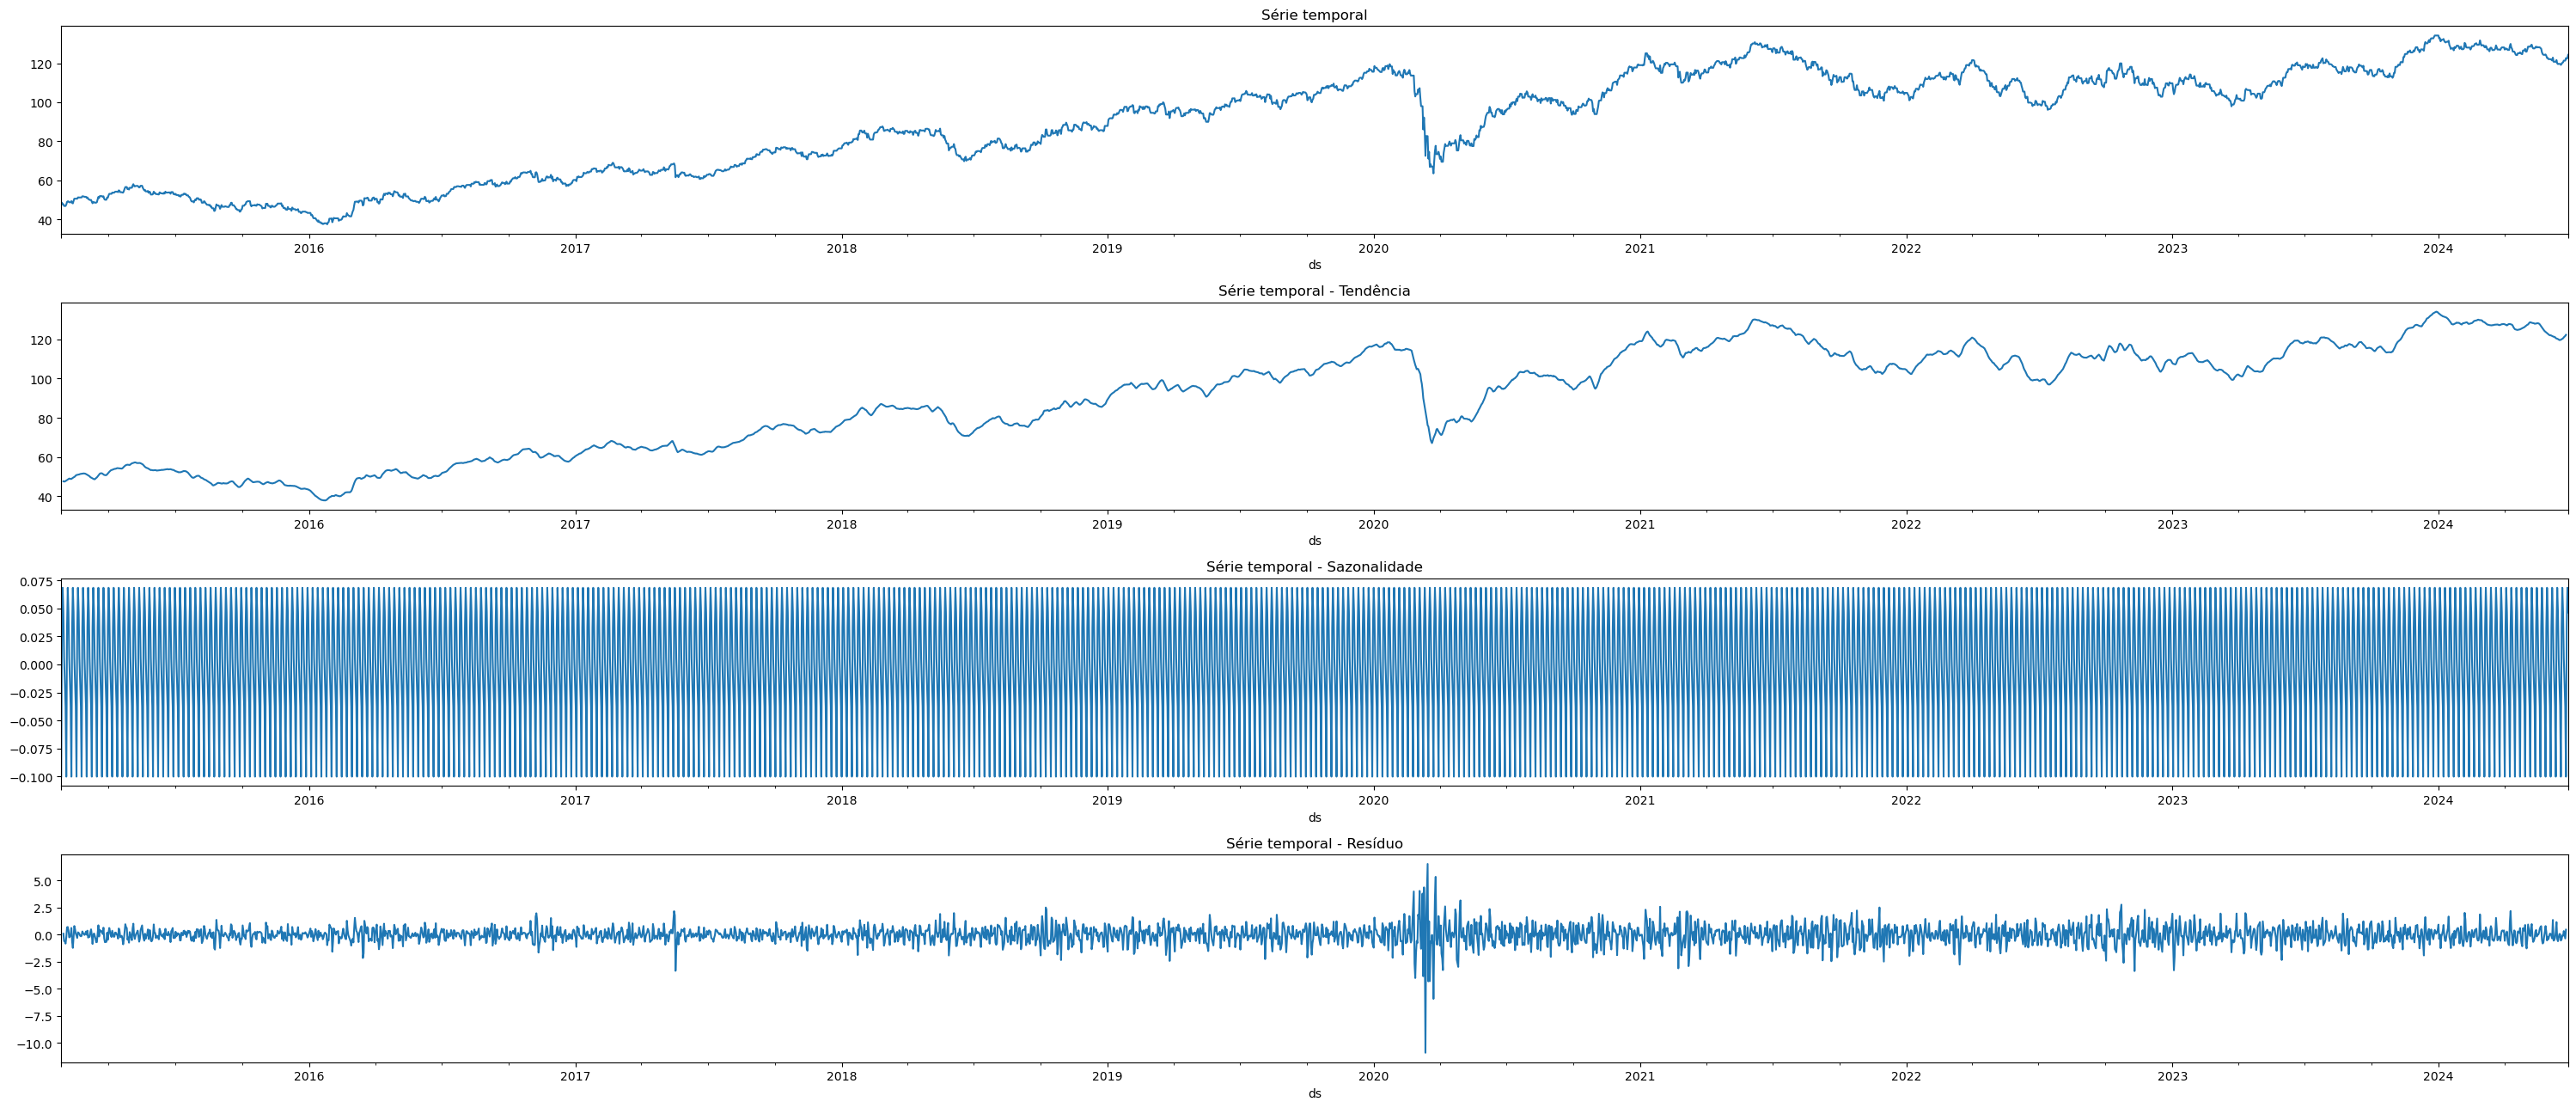

In [36]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

Não foi possível extrair insights muito valiosos com a decomposição da série temporal em seus componentes. A tendência representa a mesma curva da própria série porém um pouco mais suavizada.

A sazonalidade têm padrão caótico, indicando que não é sazonalidade aparente nos dados, o que faz bastante sentido.

Já o resíduo reforça a ideia de 2020 ser um ano fora do padrão de comportamento da curva.

## Teste ADF

- Teste ADF -> verificar se uma série temporal é estacionária ou não

- H0 = hipótese nula (não é estacionária)
- H1 = hipótese alternativa (é estacionária)

In [37]:
from statsmodels.tsa.stattools import adfuller

result_adfuller = adfuller(dados_date_index.y)

In [38]:
print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

Teste ADF
Teste estatístico: -1.534891043120695
P-value: 0.5161860935398083


Valores críticos:
1%: -3.4322607176038886
5%: -2.862384245143845
10%: -2.5672194073418937


Não é estacionária!

## Média móvel

In [39]:
# Rolling = calcula estatísticas com base em intervalos no df. Neste caso, média móvel
ma = dados_date_index.rolling(12). mean()

d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode

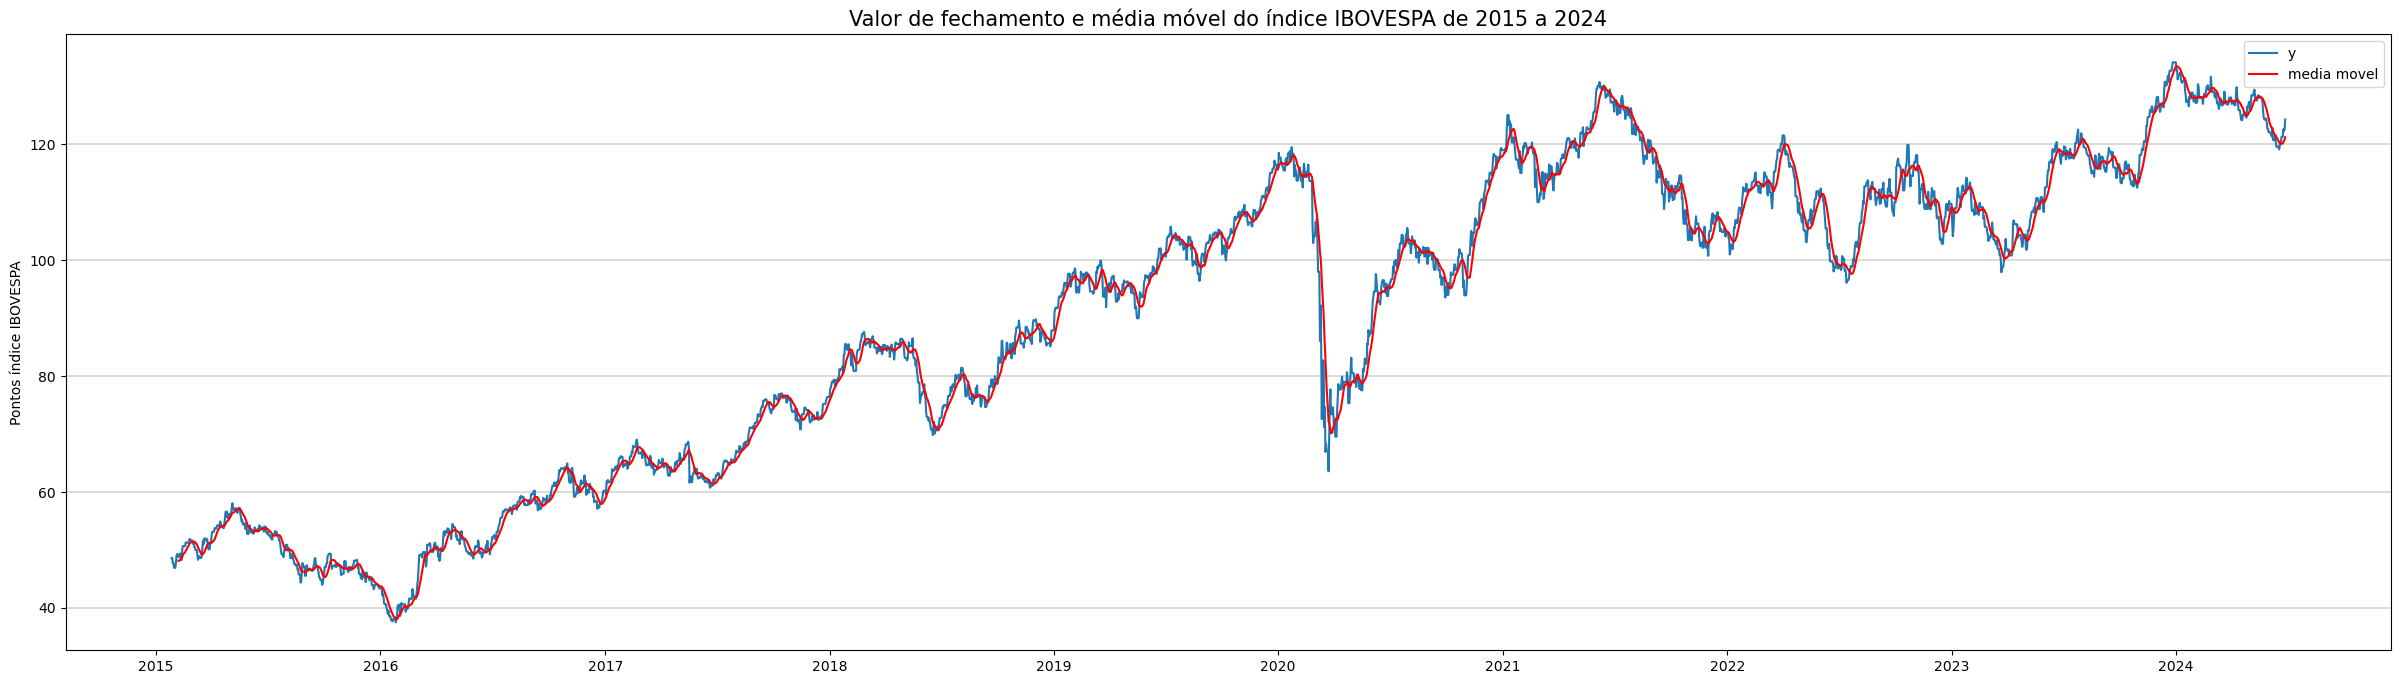

In [40]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados_date_index, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma, x='ds', y='y', ax=ax, color='r', label='media movel')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Valor de fechamento e média móvel do índice IBOVESPA de 2015 a 2024', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

Assim como a componente de tendência, a média móvel parece representar o mesmo comportamento da série original porém de maneira suavizada

# Série temporal com transformada logarítmica

## Média móvel

In [41]:
dados_log = np.log(dados_date_index)
ma_log = dados_log.rolling(12).mean()

d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode

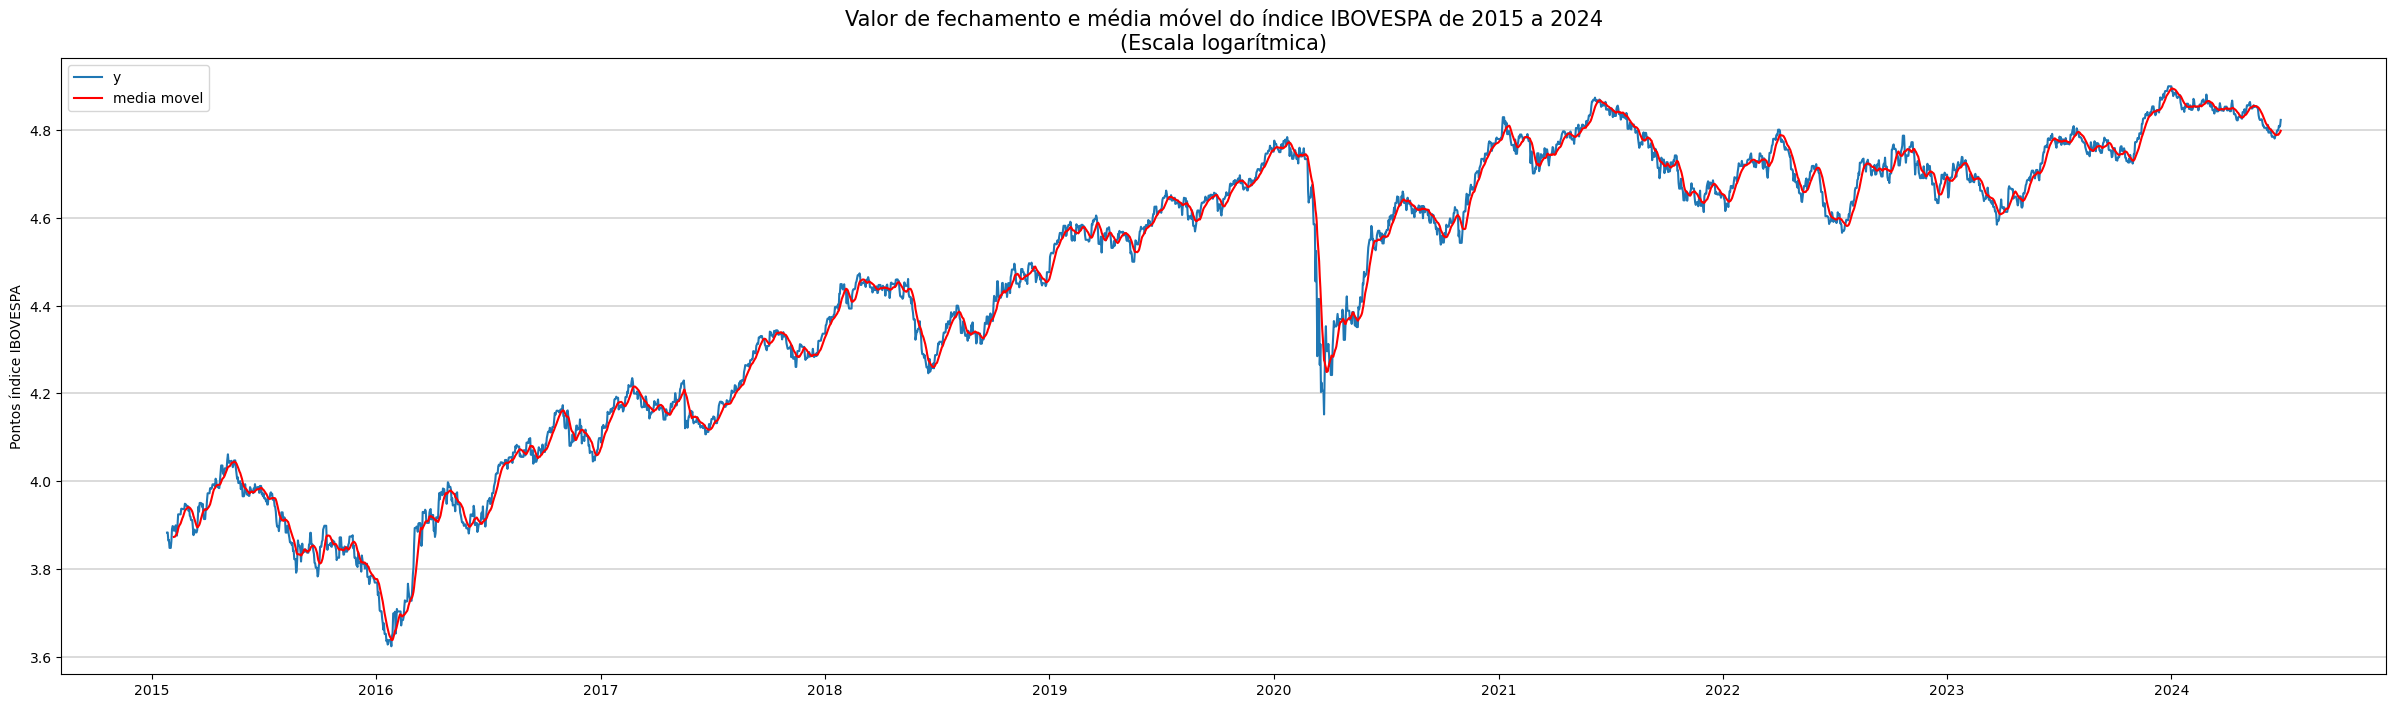

In [42]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados_log, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma_log, x='ds', y='y', ax=ax, color='r', label='media movel')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Valor de fechamento e média móvel do índice IBOVESPA de 2015 a 2024\n(Escala logarítmica)', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

## Componentes da série

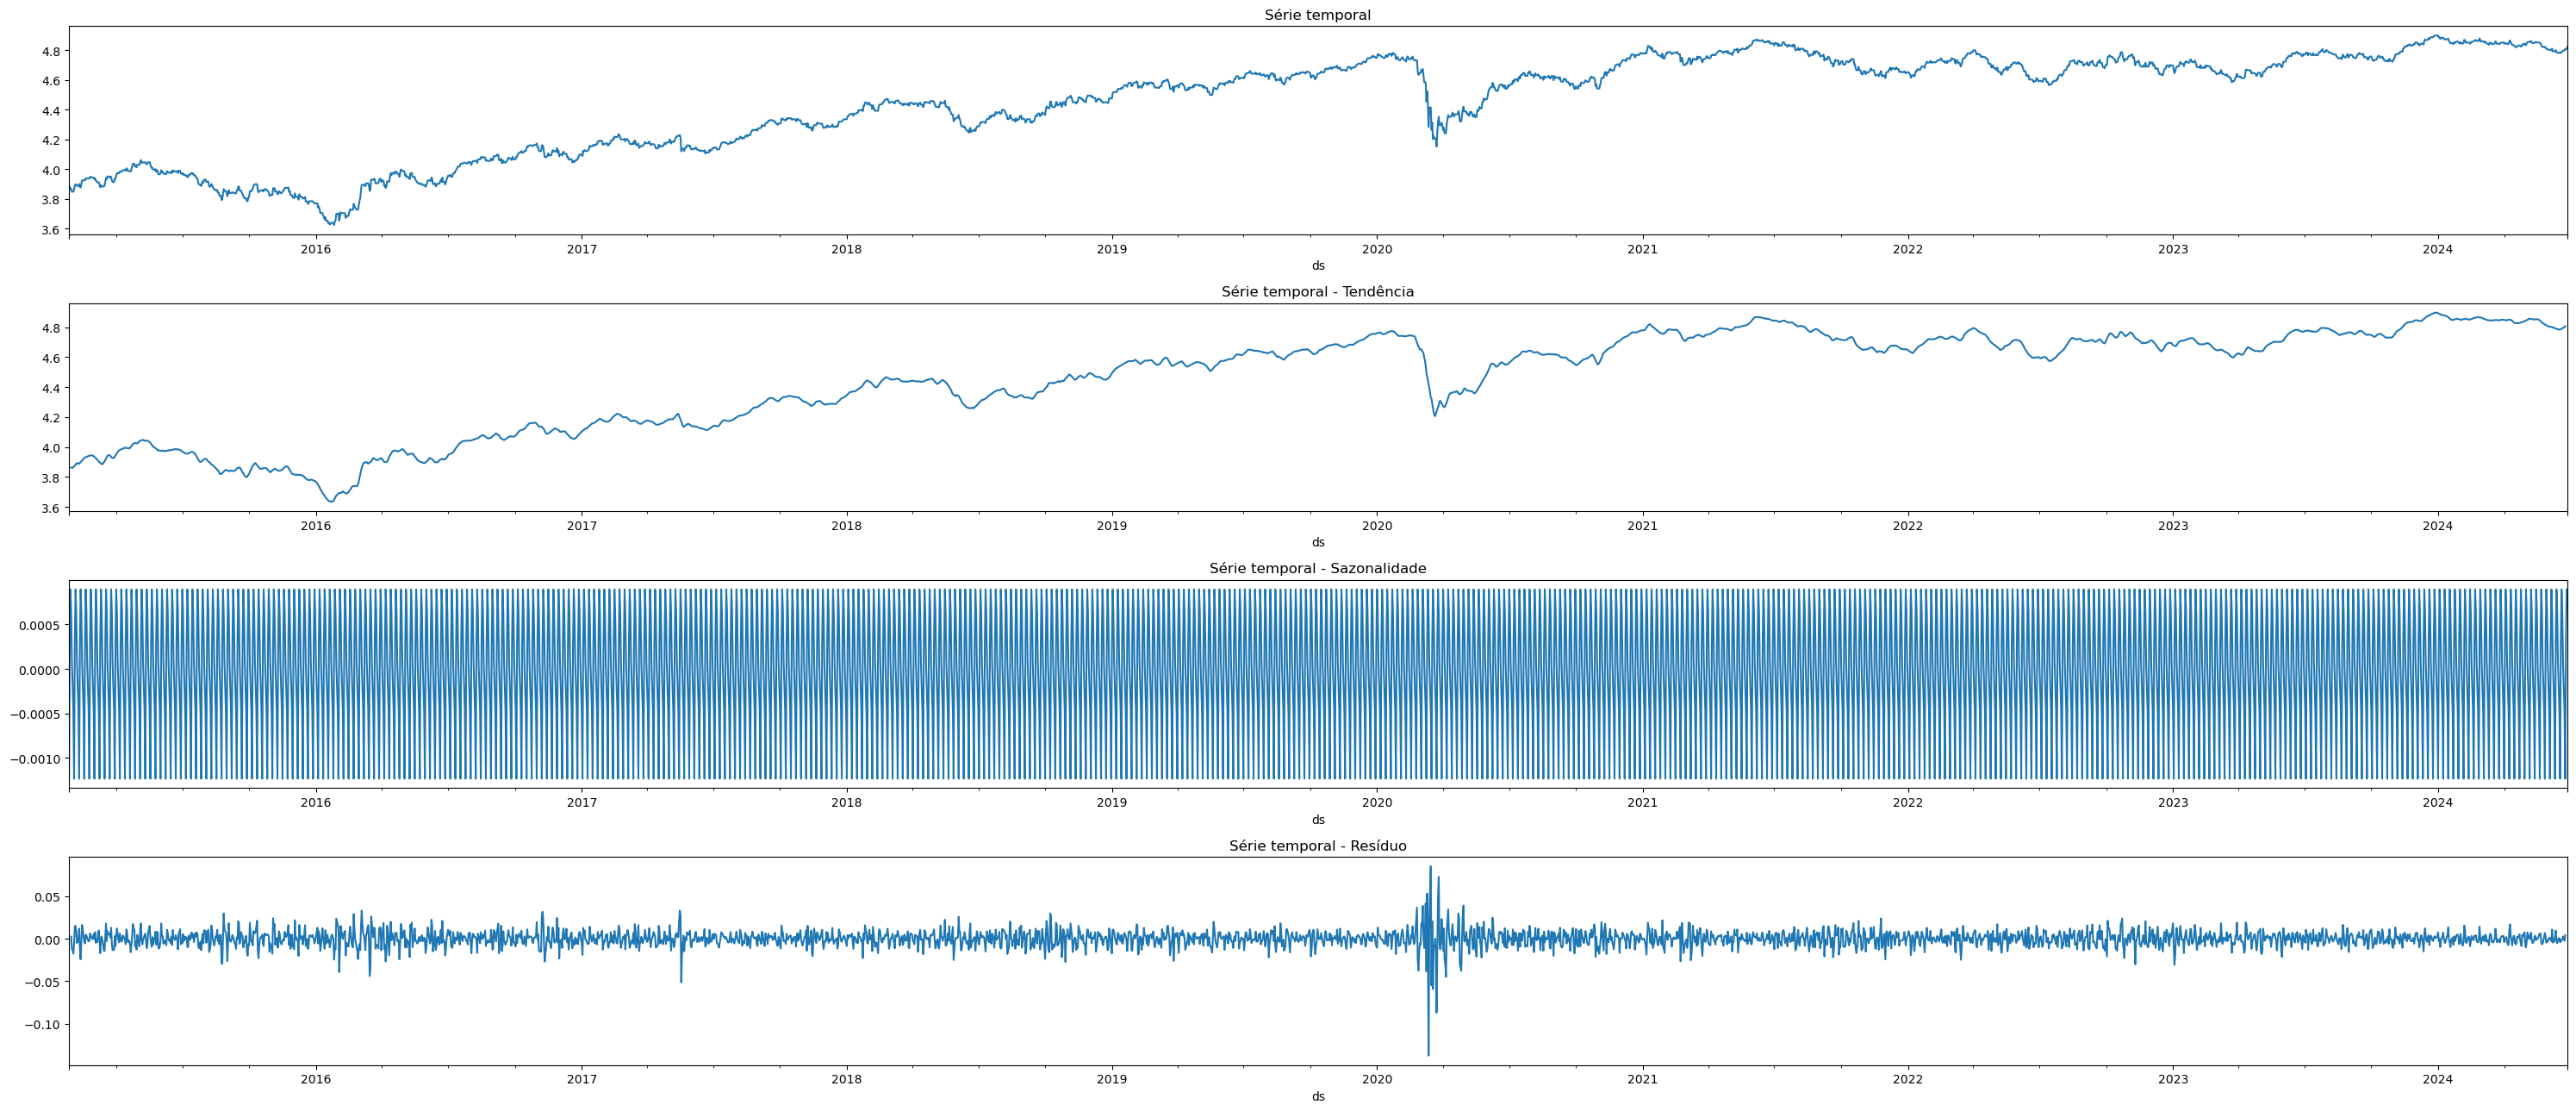

In [43]:
result = seasonal_decompose(dados_log)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

## Teste ADF

In [44]:
result_adfuller = adfuller(dados_log.y)

print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

Teste ADF
Teste estatístico: -1.5631285663086232
P-value: 0.5020839942800918


Valores críticos:
1%: -3.4322590441926377
5%: -2.862383505988867
10%: -2.567219013835542


Portanto, aplicando a transformada logarítmica não ocorreram mudanças significativas na série temporal.

# Diferença entre série temporal logarítmica e média móvel

## Média móvel

In [45]:
dados_log_subt = dados_log - ma_log
ma_subt = dados_log_subt.rolling(12).mean()
std_subt = dados_log.rolling(12).std()
dados_log_subt.dropna(inplace=True)

d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode

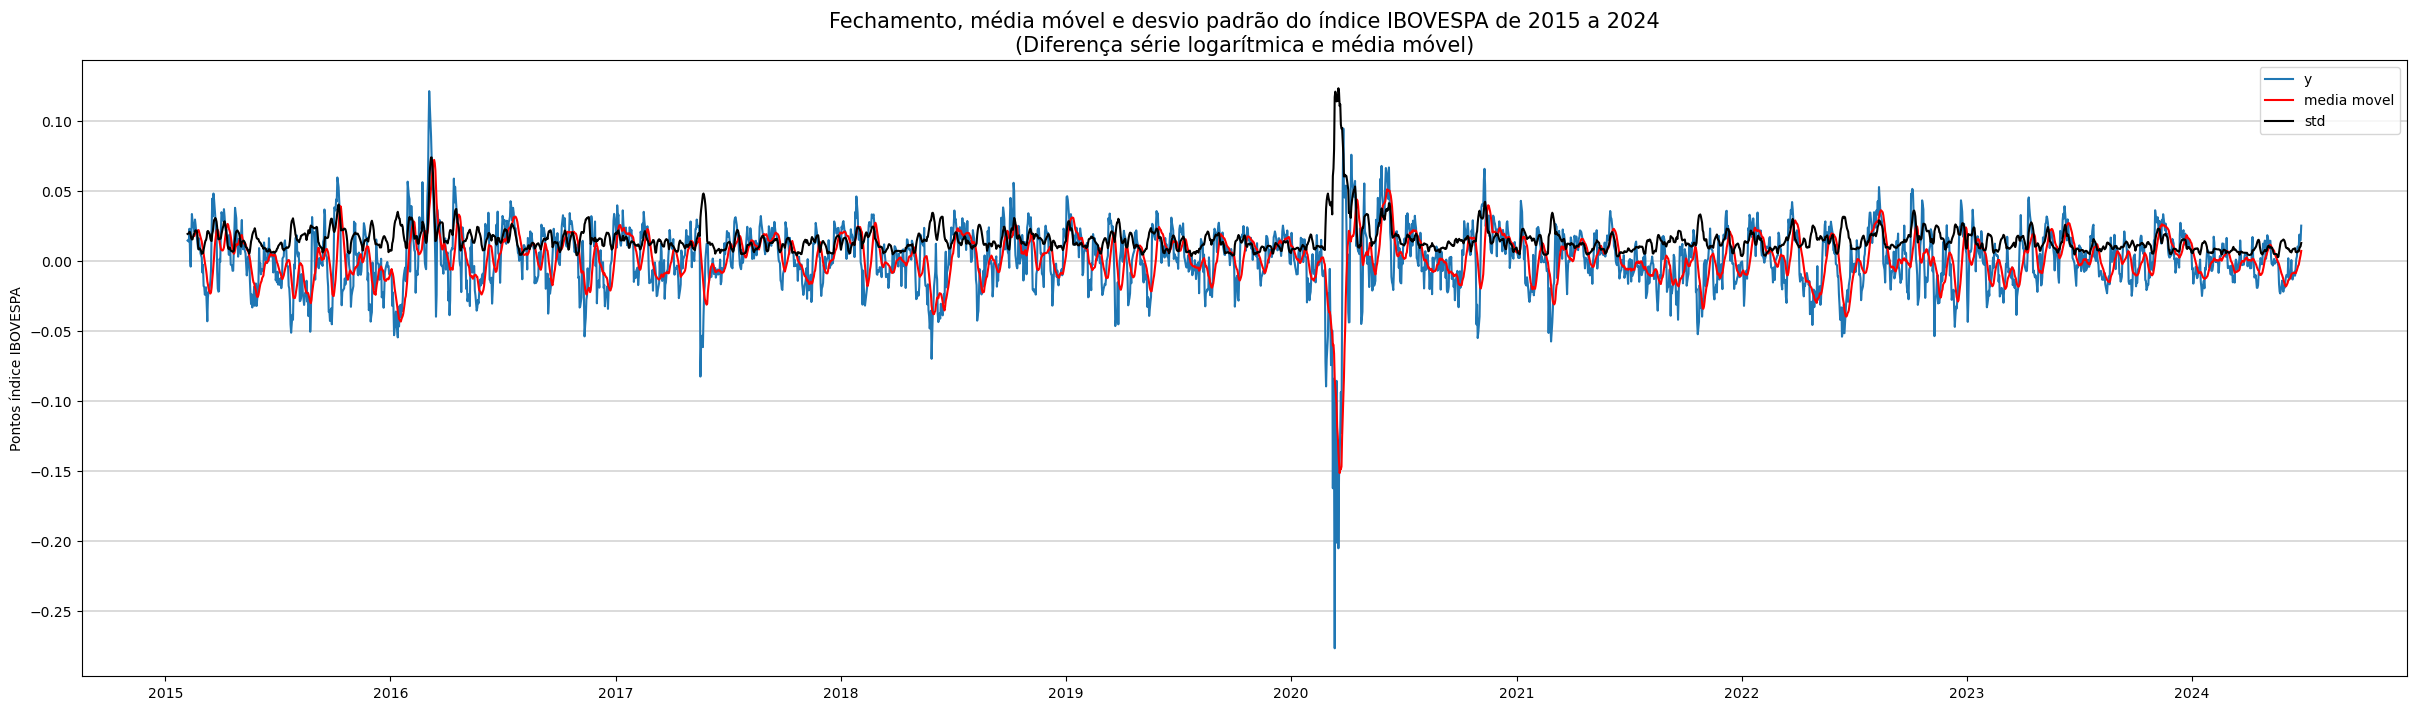

In [46]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados_log_subt, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma_subt, x='ds', y='y', ax=ax, color='r', label='media movel')
sns.lineplot(std_subt, x='ds', y='y', ax=ax, color='black', label='std')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Fechamento, média móvel e desvio padrão do índice IBOVESPA de 2015 a 2024\n(Diferença série logarítmica e média móvel)', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

## Componentes da série

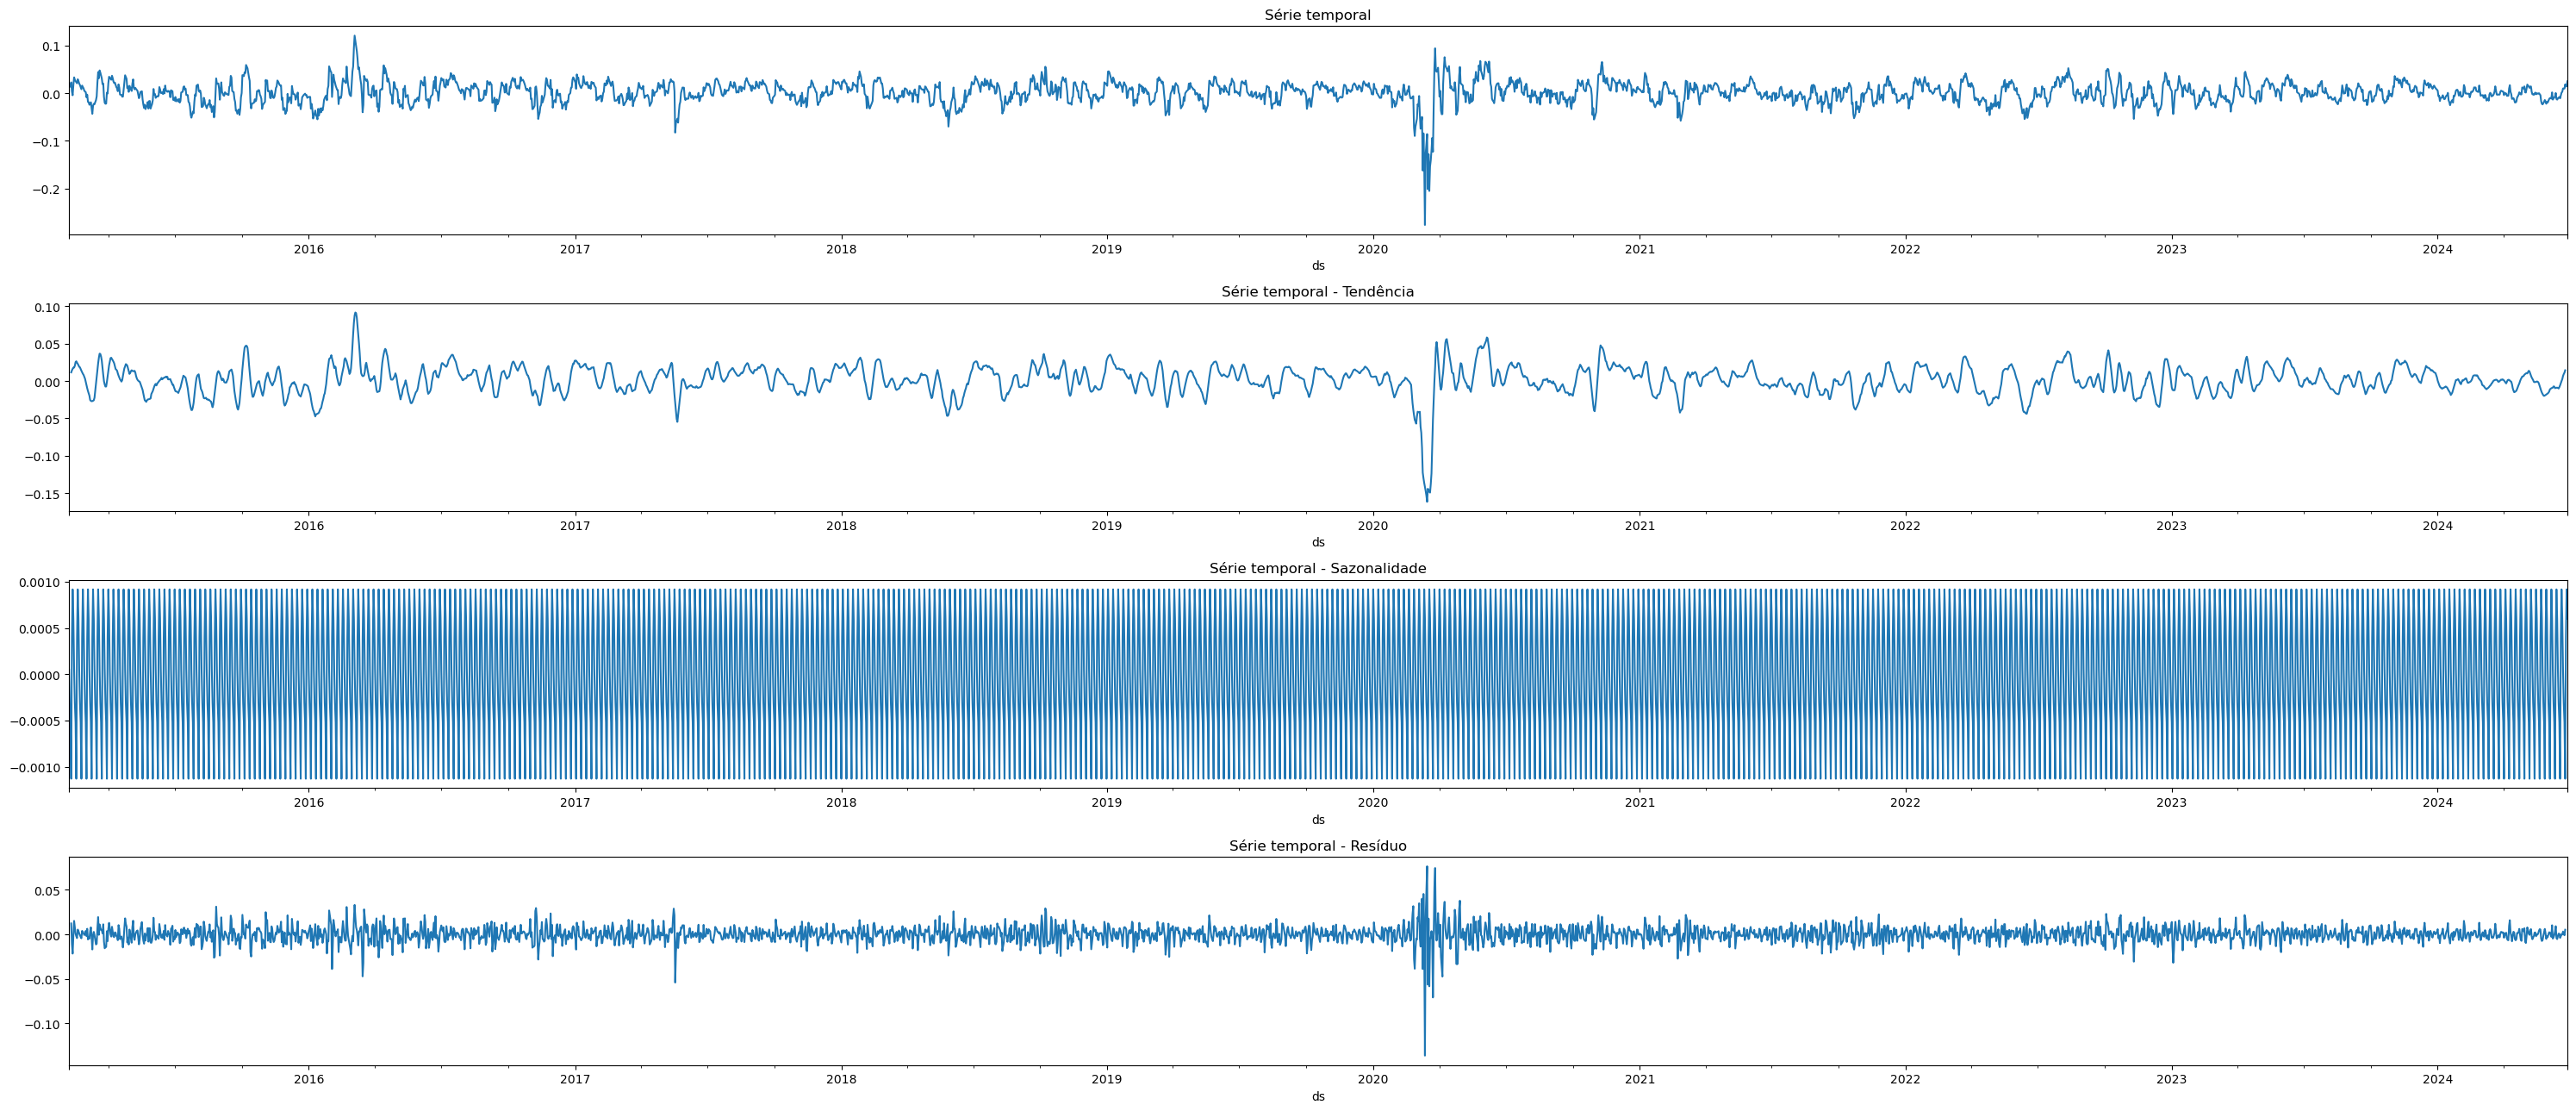

In [47]:
result = seasonal_decompose(dados_log_subt)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

## Teste ADF

In [48]:
result_adfuller = adfuller(dados_log_subt.y)

print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

if(result_adfuller[1] < result_adfuller[4]['5%']):
    print('H0 nula confirmada, não é estacionária')
else:
    print('H1 alternativa confirmada, é estacionária')

Teste ADF
Teste estatístico: -11.77554605682472
P-value: 1.0646350001419456e-21


Valores críticos:
1%: -3.4322640732430254
5%: -2.8623857273469064
10%: -2.5672201964273937
H1 alternativa confirmada, é estacionária


Desta vez, a diferença entre a série em escala logarítmica e a média móvel resultou em uma série temporal mais constante, visualmente com caráter estacionário.

Tal hipótese foi confirmada com o teste ADF que indicou uma série temporal estacionária.

# Série temporal derivada

## Média móvel

In [49]:
dados_diff = dados_log_subt.diff(1)
ma_diff = dados_diff.rolling(12).mean()
std_diff = dados_diff.rolling(12).std()
dados_diff.dropna(inplace=True)

dados_diff

y
ds                  
2015-02-07 -0.000368
2015-02-08 -0.000344
2015-02-09  0.009142
2015-02-10 -0.019131
2015-02-11 -0.007915
...              ...
2024-06-23  0.000202
2024-06-24  0.008768
2024-06-25 -0.004402
2024-06-26  0.000482
2024-06-27  0.010327

[3429 rows x 1 columns]

d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode

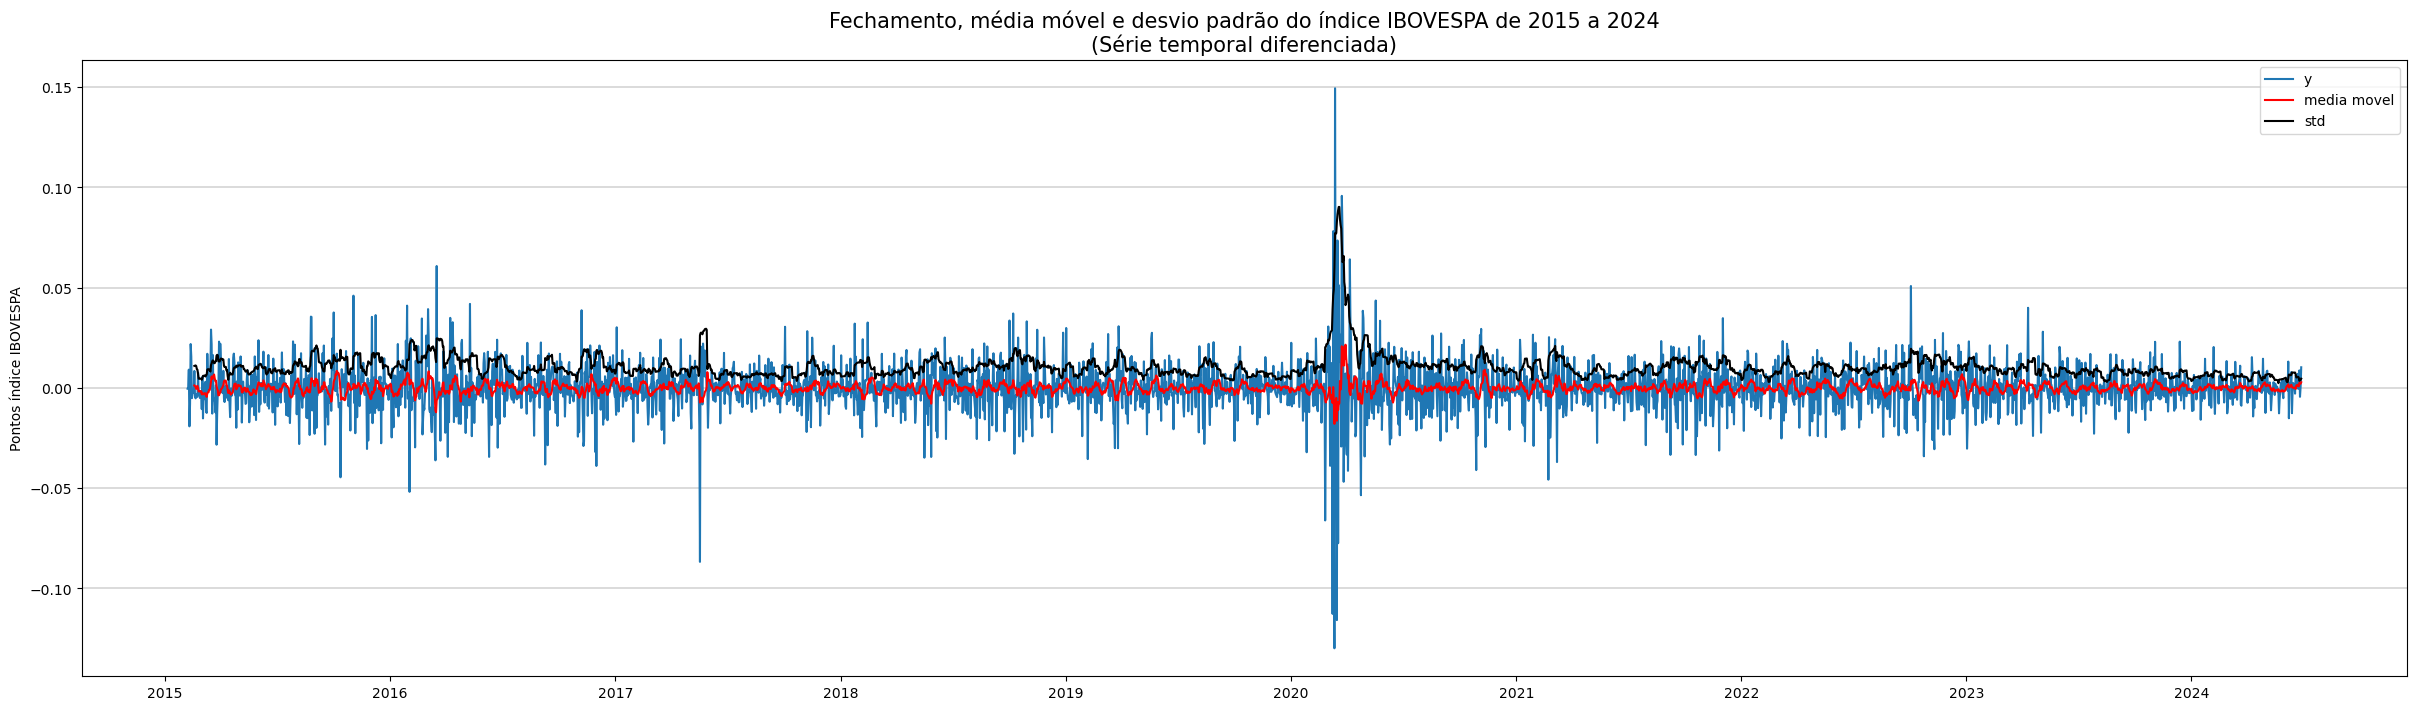

In [50]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(dados_diff, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma_diff, x='ds', y='y', ax=ax, color='r', label='media movel')
sns.lineplot(std_diff, x='ds', y='y', ax=ax, color='black', label='std')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Fechamento, média móvel e desvio padrão do índice IBOVESPA de 2015 a 2024\n(Série temporal diferenciada)', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

## Componentes da série

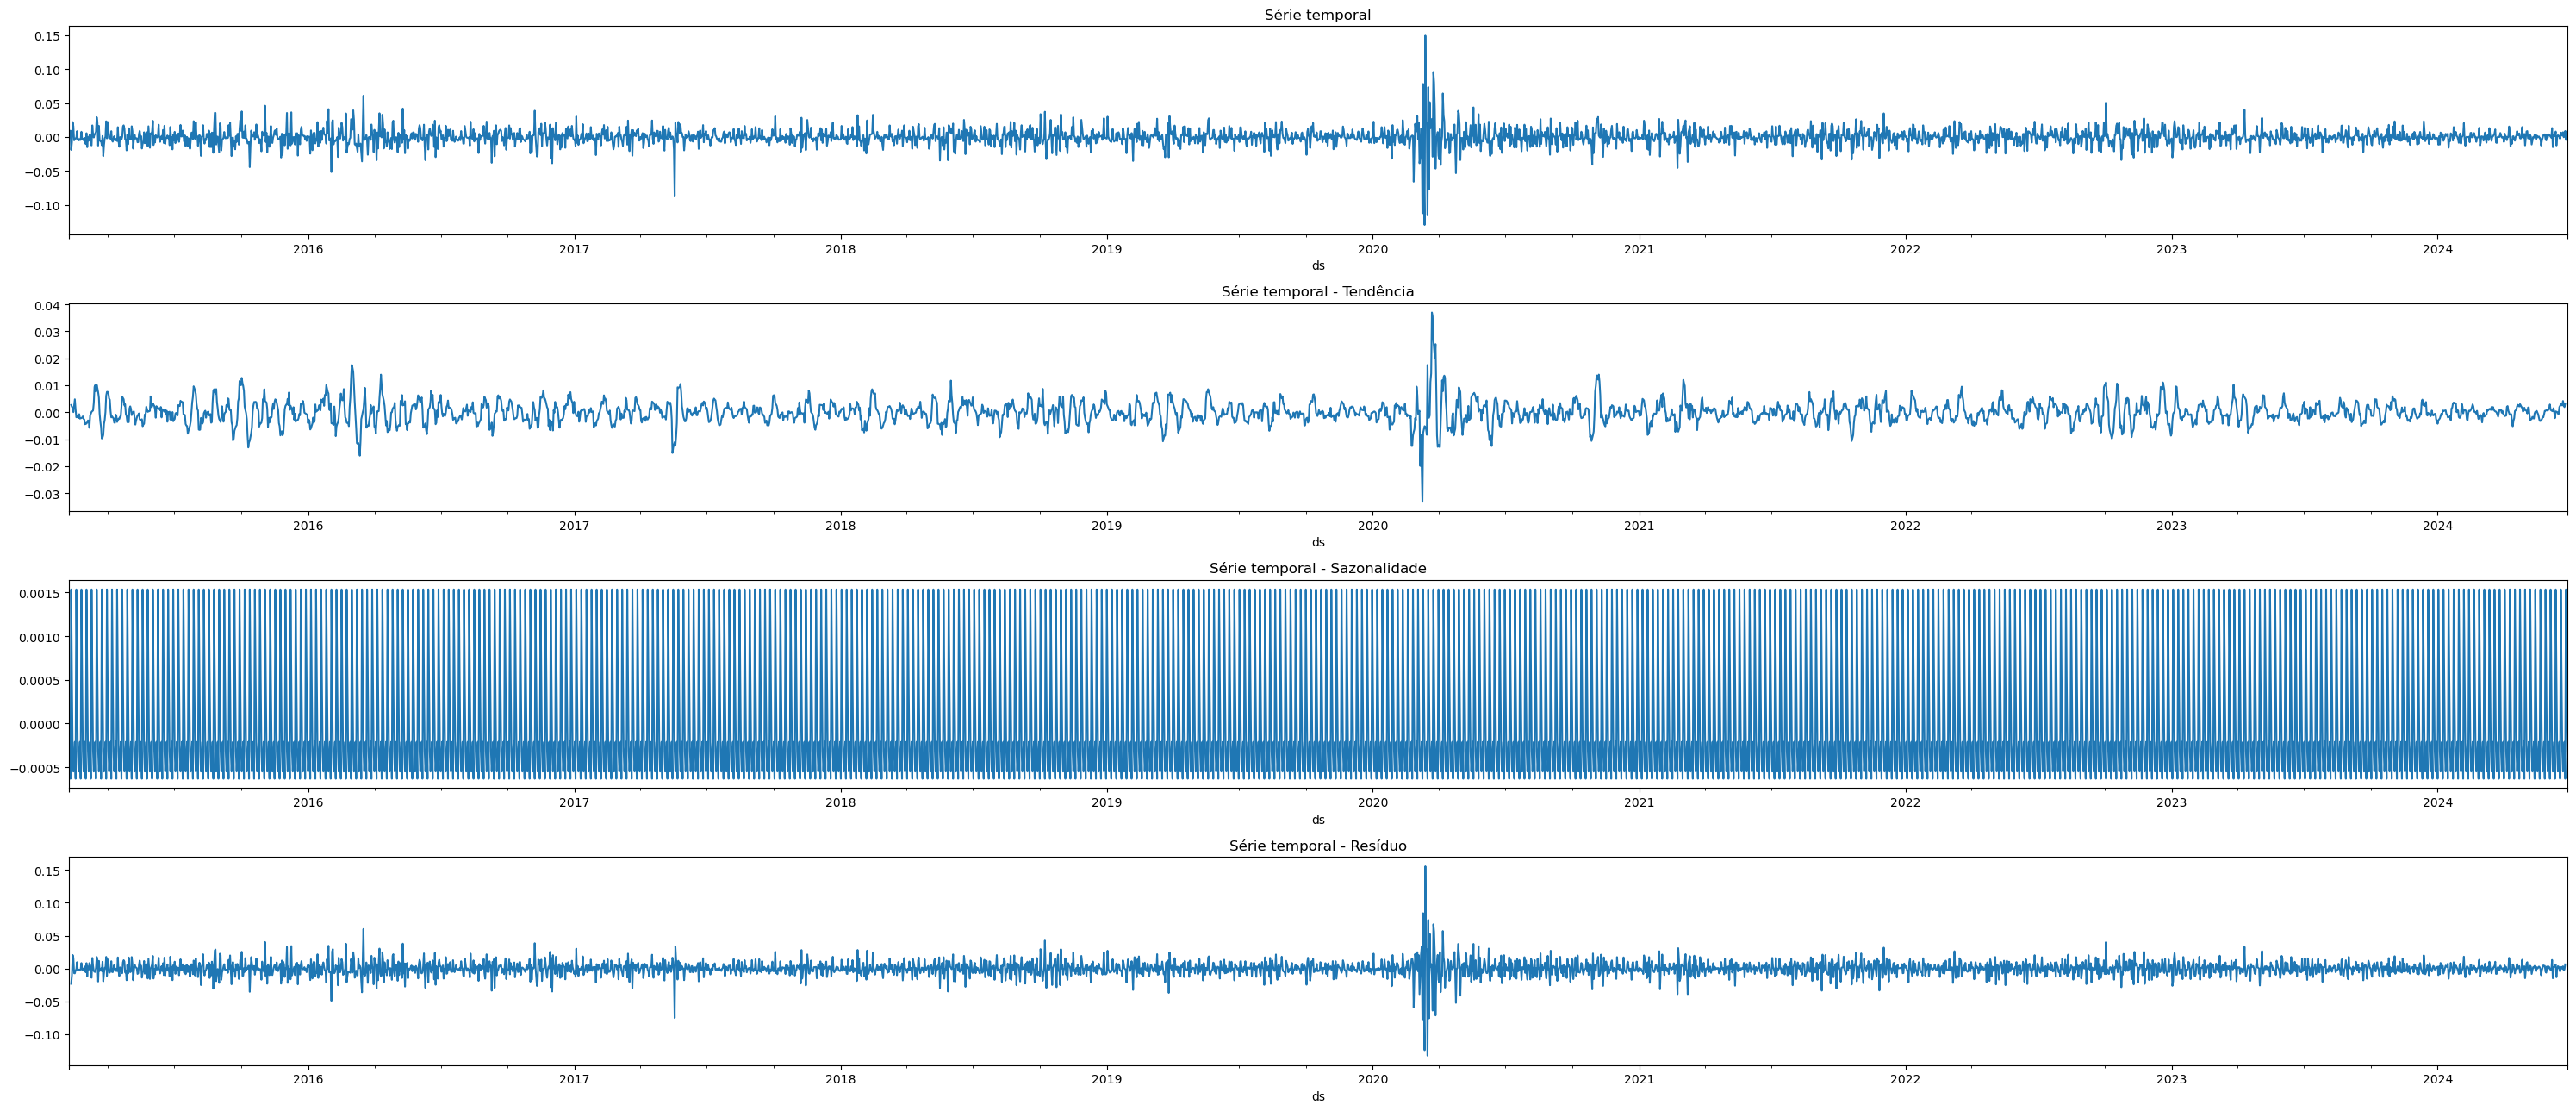

In [51]:
result = seasonal_decompose(dados_diff)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

## Teste ADF

In [52]:
result_adfuller = adfuller(dados_diff.y)

print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

if(result_adfuller[1] < result_adfuller[4]['5%']):
    print('H0 nula confirmada, não é estacionária')
else:
    print('H1 alternativa confirmada, é estacionária')

Teste ADF
Teste estatístico: -16.443012453675752
P-value: 2.4178426388181676e-29


Valores críticos:
1%: -3.4322742112538958
5%: -2.8623902053483077
10%: -2.567222580397986
H1 alternativa confirmada, é estacionária


Novamente, tem-se uma série temporal visualmente muito mais constante, com aspecto estacionário.

O o teste ADF confirmar a hipótese de série temporal estacionária.

# ACF e PACF

Com as séries temporais estacionárias obtidas a partir da diferenciação da série original, podem ser calculados os valores de ACF (Autocorrelation Function) e PACF (Partial Autocorrelation Function).

Esta análise traz importantes resultados sobre a sazonalidade e a randomicidade da série temporal, bem como indica o grau de correlação entre os próprios intervalos de tempo existentes na série temporal.

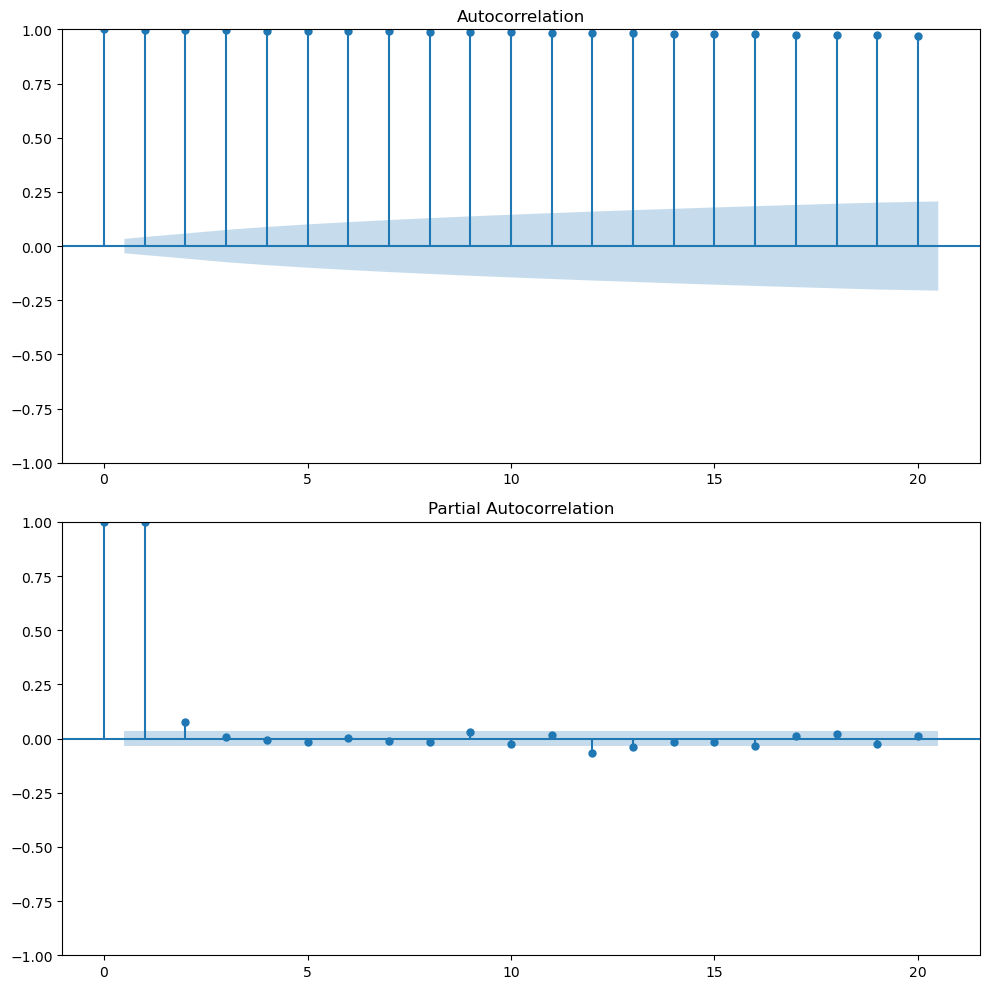

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

plot_acf(dados_date_index.y, lags=20, ax=ax[0])
plot_pacf(dados_date_index.y, lags=20, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

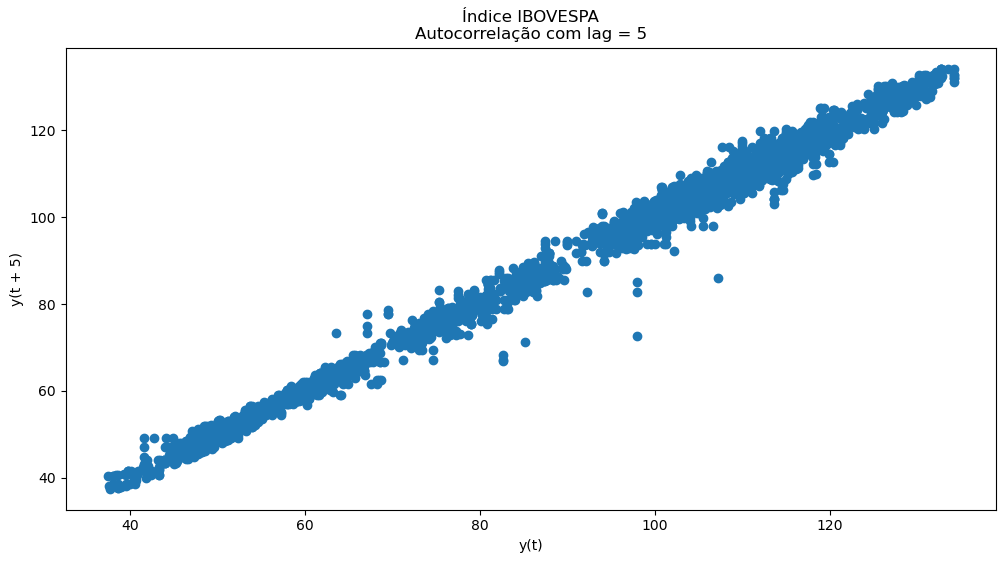

In [54]:
plt.figure(figsize=(12, 6))

lag_plot(dados_date_index.y, lag=5)

plt.title('Índice IBOVESPA\nAutocorrelação com lag = 5')

plt.show()

Com os gráficos, confirma-se a existência de autocorrelação na série temporal, especialmente com lags pequenos, ou seja, em um intervalo de dias reduzido.

É perceptível uma forte autocorrelação na série temporal do IBOVESPA em intervalos de 5 dias (lag = 5), ou seja, analisando um período de 5 dias geralmente serão observados valores do índice muito semelhantes.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

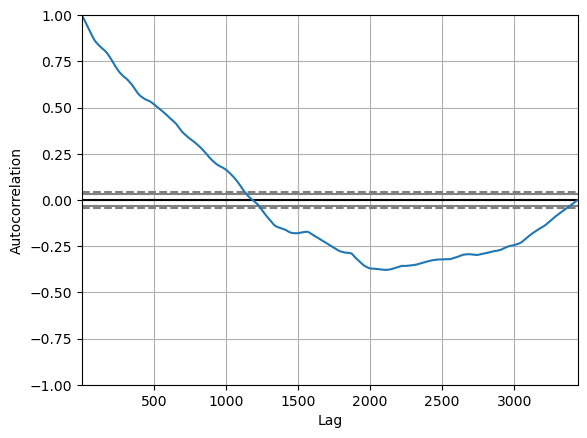

In [55]:
autocorrelation_plot(dados_date_index)

# Datasets de treino e teste

In [56]:
train_set_date_col = dados_date_col.loc[dados_date_col.ds < '2022-01-01']
test_set_date_col = dados_date_col.loc[dados_date_col.ds >= '2022-01-01']
train_set_date_index = dados_date_index.loc[dados_date_index.index < '2022-01-01']
test_set_date_index = dados_date_index.loc[dados_date_index.index >= '2022-01-01']


print(len(train_set_date_col))
print(len(test_set_date_col))

2532
909


# Modelos NAIVE

Modelos NAIVE são relativamente simples e geralmente são usados como primeira alternativa, para se ter uma ideia de baseline de desempenho para os próximos modelos explorados.

Serão utilizados os seguintes modelos:
- Naive
- SeasonalNaive
- WindowAverage
- SeasonalWindowAverage


Como esperado, os diferentes modelos Naive não atenderam à demanda do problema que lida com uma série temporal muito caótica, sem sazonalidade ou padrão algum.


Em seguida, serão testados modelos mais complexos, como o ARIMA.

# Modelo ARIMA

**Parâmetros:**
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

## Modelo ARIMA padrão

Será usado um lag de 5 dias no parãmetro p, tendo em vista que há forte autocorrelação nesse intervalo na série temporal.

In [57]:
arima_model = ARIMA(train_set_date_index, order=(5,1,0))

In [58]:
arima_model_fit = arima_model.fit()

In [59]:
y_pred = arima_model_fit.forecast(len(test_set_date_index))

In [60]:
residuals = pd.DataFrame(arima_model_fit.resid)

In [61]:
y_pred

2022-01-01    104.800567
2022-01-02    104.781616
2022-01-03    104.804040
2022-01-04    104.801549
2022-01-05    104.801150
                 ...    
2024-06-23    104.801215
2024-06-24    104.801215
2024-06-25    104.801215
2024-06-26    104.801215
2024-06-27    104.801215
Freq: D, Name: predicted_mean, Length: 909, dtype: float64

d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\AnaCondaDir\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode

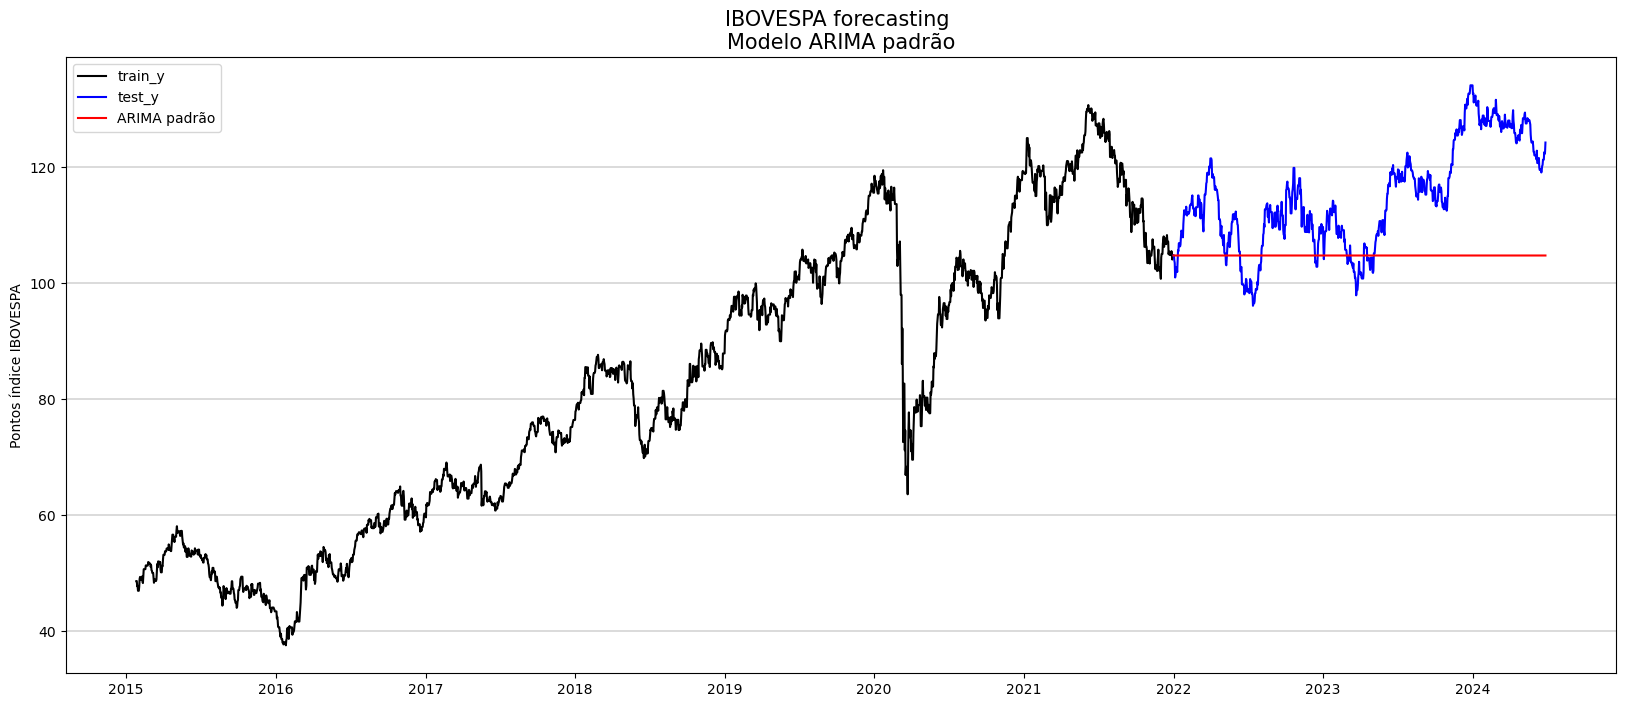

ARIMA padrão WMAPE: 9.63%
ARIMA padrão Test RMSE: 13.51
ARIMA padrão MAE: 11.07


In [62]:
model_ = 'ARIMA padrão'

fig, ax = plt.subplots(figsize=(20,8))

sns.lineplot(train_set_date_index, x='ds', y='y', ax=ax, label='train_y', color='black')
sns.lineplot(test_set_date_index, x='ds', y='y', ax=ax, color='blue', label='test_y')
sns.lineplot(y_pred, ax=ax, color='red', label='ARIMA padrão')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('IBOVESPA forecasting \nModelo ARIMA padrão', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

wmape_ = calc_wmape(test_set_date_index.y.values, y_pred.values)
rmse_ = sqrt(mean_squared_error(test_set_date_index.y.values, y_pred.values))
mae_ = calc_mae(test_set_date_index.y.values, y_pred.values)

print(f'{model_} WMAPE: {wmape_:.2%}')
print(f'{model_} Test RMSE: %.2f' % rmse_)
print(f'{model_} MAE: %.2f' % mae_)

In [63]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2532
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3845.994
Date:                Sat, 27 Jul 2024   AIC                           7703.988
Time:                        20:06:45   BIC                           7739.006
Sample:                    01-26-2015   HQIC                          7716.693
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1051      0.008    -12.372      0.000      -0.122      -0.088
ar.L2         -0.0025      0.009     -0.272      0.786      -0.021       0.016
ar.L3      -8.707e-06      0.010     -0.001      0.9

Apesar do valor baixo no WMAPE, analisando a curva é visível que o modelo não performou bem, pois foi prevista uma linha constante, muito distante do comportamento da série temporal que possui diversos altos e baixos.

Uma das hipóteses é que o modelo está utilizando o comportamente do dataset de treino para fazer todas as previsões do dataset de teste, quando, na verdade, a cada nova previsão o modelo deveria passar por um novo ajuste de acordo com o valor previsto.

## Modelo ARIMA "retroalimentado"

Para isso, será aplicada a lógica de um laço de repetiçao, em que a cada execução uma nova previsão é realizada e um novo ajuste é feito no modelo ARIMA.

Dessa forma, a cada nova previsão será usado um novo conjunto de treino para o modelo, dando mais dinamicidade à previsão da curva.

In [64]:
import warnings
warnings.filterwarnings("ignore")

In [65]:
history

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
def calculate_wmape(actual, forecast, weights=None):
    """
    Calculate the Weighted Mean Absolute Percentage Error (WMAPE) between two series.

    Parameters:
    actual (list or array): The actual values.
    forecast (list or array): The forecasted values.
    weights (list or array, optional): Weight for each observation. Default is None (equal weights).

    Returns:
    float: The calculated WMAPE.
    """
    if len(actual) != len(forecast):
        raise ValueError("Both series must have the same length.")

    if weights is None:
        weights = [1] * len(actual)

    if len(weights) != len(actual):
 

In [66]:
y_pred_step = []
history = train_set_date_index.copy()

for i in range(len(test_set_date_index)):
    model_arima_retro = ARIMA(history, order=(5,1,0))
    model_arima_retro_fit = model_arima_retro.fit()

    output = model_arima_retro_fit.forecast(disp=0)
    yhat = output[0]
    y_pred_step.append(yhat)

    obs = test_set_date_index.values[i]

    history = pd.concat([history, pd.DataFrame({'y':obs}, index=[test_set_date_index.index[i]])])

    print('predicted=%f, expected=%f' % (yhat, obs))

y_pred = test_set_date_index.copy()
y_pred.y = y_pred_step

predicted=104.800567, expected=104.822000
predicted=104.800793, expected=104.822000
predicted=104.842371, expected=103.922000
predicted=104.016598, expected=103.514000
predicted=103.559078, expected=101.006000
predicted=101.268952, expected=101.561000
predicted=101.482080, expected=102.719000
predicted=102.586003, expected=102.719000
predicted=102.646441, expected=102.719000
predicted=102.734459, expected=101.945000
predicted=102.057974, expected=103.779000
predicted=103.589250, expected=105.686000
predicted=105.482467, expected=105.530000
predicted=105.516967, expected=106.928000
predicted=106.833478, expected=106.928000
predicted=106.980857, expected=106.928000
predicted=106.926581, expected=106.374000
predicted=106.470396, expected=106.668000
predicted=106.640194, expected=108.013000
predicted=107.872694, expected=109.102000
predicted=108.970778, expected=108.942000
predicted=108.962915, expected=108.942000
predicted=108.980292, expected=108.942000
predicted=108.974795, expected=107

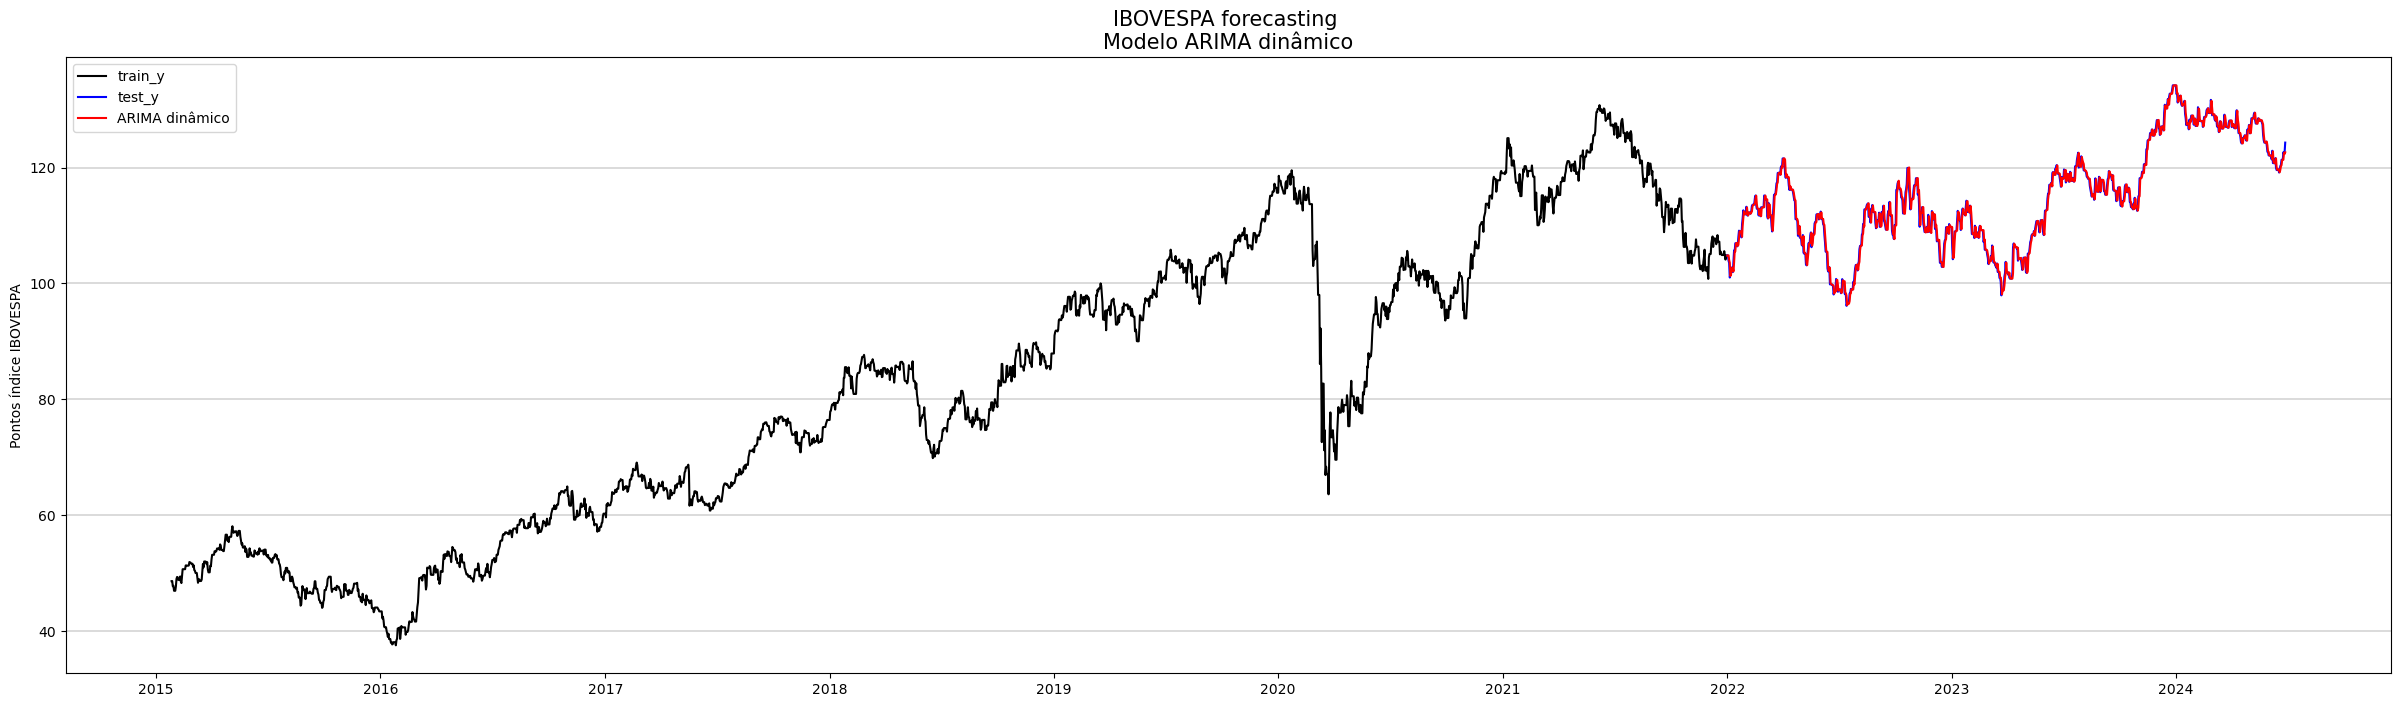

ARIMA dinâmico WMAPE: 0.62%
ARIMA dinâmico Test RMSE: 1.06
ARIMA dinâmico MAE: 0.71


In [67]:
model_ = 'ARIMA dinâmico'

fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(train_set_date_index, x='ds', y='y', ax=ax, label='train_y', color='black')
sns.lineplot(test_set_date_index, x='ds', y='y', ax=ax, color='blue', label='test_y')
sns.lineplot(y_pred, x='ds', y='y', ax=ax, color='red', label=f'{model_}')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title(f'IBOVESPA forecasting \nModelo {model_}', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

wmape_ = calc_wmape(test_set_date_index.y.values, y_pred.y.values)
rmse_ = sqrt(mean_squared_error(test_set_date_index.y.values, y_pred.y.values))
mae_ = calc_mae(test_set_date_index.y.values, y_pred.y.values)

print(f'{model_} WMAPE: {wmape_:.2%}')
print(f'{model_} Test RMSE: %.2f' % rmse_)
print(f'{model_} MAE: %.2f' % mae_)

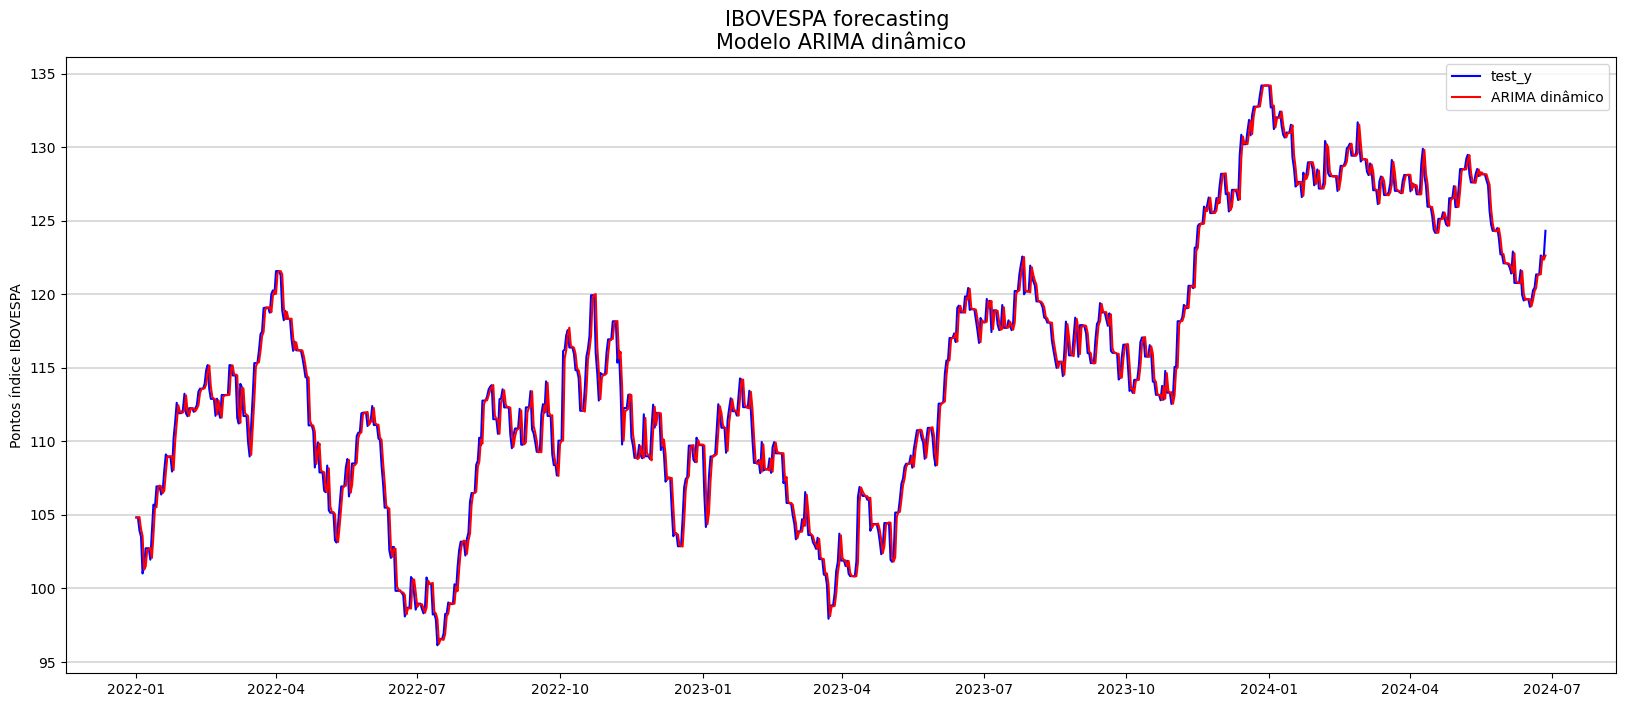

ARIMA dinâmico WMAPE: 0.62%
ARIMA dinâmico Test RMSE: 1.06
ARIMA dinâmico MAE: 0.71


In [68]:
model_ = 'ARIMA dinâmico'

fig, ax = plt.subplots(figsize=(20,8))

sns.lineplot(test_set_date_index, x='ds', y='y', ax=ax, color='blue', label='test_y')
sns.lineplot(y_pred, x='ds', y='y', ax=ax, color='red', label=f'{model_}')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title(f'IBOVESPA forecasting \nModelo {model_}', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

wmape_ = calc_wmape(test_set_date_index.y.values, y_pred.y.values)
rmse_ = sqrt(mean_squared_error(test_set_date_index.y.values, y_pred.y.values))
mae_ = calc_mae(test_set_date_index.y.values, y_pred.y.values)

print(f'{model_} WMAPE: {wmape_:.2%}')
print(f'{model_} Test RMSE: %.2f' % rmse_)
print(f'{model_} MAE: %.2f' % mae_)